In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd ./drive/MyDrive/RRCGAN_SMILES_publish/model
! pwd

/content/drive/MyDrive/RRCGAN_SMILES_publish/model
/content/drive/MyDrive/RRCGAN_SMILES_publish/model


In [3]:
# Strategy 1:
# Generate data after each epoch of training, if less than
# 10% error rate, and is a legit SMILES
# append to the real data
# Otherwise, append to fake data

# ADDING REINFORCEMENT MECHANISM
# Regenerate Normal sampling (define ranges), default: uniform

# IMPORTANT!!!!!!!!!!!!! DO NOT DROP DUPLICATE FOR RESULT .CSV

import warnings
warnings.filterwarnings('ignore')

import time
import os
import re
import pandas as pd
import random

import numpy as np
from numpy import ndarray

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from scipy.stats import truncnorm

import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Dropout, LSTM, Reshape, LeakyReLU,
                          Concatenate, ReLU, Flatten, Dense, Embedding,
                          BatchNormalization, Activation, SpatialDropout1D,
                          Conv2D, MaxPooling2D, UpSampling2D, Lambda)
from tensorflow.keras.models     import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import mse, binary_crossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import  mean_squared_error as mse_keras
from tensorflow.keras.backend import argmax as argmax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import one_hot

from tensorflow.keras.utils import  to_categorical
from tensorflow import random as randomtf

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from   matplotlib.lines import Line2D
from   matplotlib.colors import ListedColormap
import matplotlib.ticker as tk

from progressbar import ProgressBar
import seaborn as sns

!pip install rdkit-pypi
!pip install chainer-chemistry
from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor, construct_atomic_number_array
preprocessor = GGNNPreprocessor()
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem

import ntpath
from scipy.stats import truncnorm

""" fix all the seeds,results are still slighthly different """
randomtf.set_seed(1)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(12345)
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3667)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options=gpu_options)
#tf.set_random_seed(1234)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 207 kB 28.7 MB/s 
     |████████████████████████████████| 1.0 MB 62.7 MB/s 
     |████████████████████████████████| 78 kB 9.0 MB/s 
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=c8cb1358ed09d1b229ece8c5c2fd4a6365bfbfd9898c024fd2e2bee7c49857a9
  Stored in directory: /root/.cache/pip/wheels/c8/6a/6f/fd563166cc597e5206e375ea074ea836e5db5dd58421215672
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=fa8cc59dcd5a8b02ab84982144b9121a35d314acc57087c1117f5beda66ea525
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built chainer typing


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
""" reading and preprocessing data"""
with open('./../data/trainingsets/60000_train_regular_qm9/image_train.pickle', 'rb') as f:
    X_smiles_train, SMILES_train, X_atoms_train, X_bonds_train, y_train0 = pickle.load(f)
    
with open('./../data/trainingsets/60000_train_regular_qm9/image_test.pickle', 'rb') as f:
    X_smiles_val, SMILES_val, X_atoms_val, X_bonds_val, y_val0 = pickle.load(f)

with open('./../data/trainingsets/60000_train_regular_qm9/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '

In [7]:
# Subsampling has been done in the data preprocesses
print ('X_smiles_train shape: ', X_smiles_train.shape)
print ('X_smiles_test shape: ', X_smiles_val.shape)
#print ('last SMILES train: ', SMILES_train[-1])

## Outlier removal 1.5*IQR rule
# Train samples
IQR = - np.quantile(y_train0, 0.25) + np.quantile(y_train0, 0.75)
lower_bound, upper_bound = np.quantile(y_train0, 0.25) - 1.5 * IQR, np.quantile(y_train0, 0.75) + 1.5 * IQR
idx = np.where((y_train0 >= lower_bound) & (y_train0 <= upper_bound))

y_train = y_train0[idx]
X_smiles_train = X_smiles_train[idx]
X_atoms_train = X_atoms_train[idx]
X_bonds_train = X_bonds_train[idx]

# Test samples
IQR = - np.quantile(y_val0, 0.25) + np.quantile(y_val0, 0.75)
lower_bound, upper_bound = np.quantile(y_val0, 0.25) - 1.5 * IQR, np.quantile(y_val0, 0.75) + 1.5 * IQR
idx = np.where((y_val0 >= lower_bound) & (y_val0 <= upper_bound))

y_val = y_val0[idx]
X_smiles_val = X_smiles_val[idx]
X_atoms_val = X_atoms_val[idx]
X_bonds_val = X_bonds_val[idx]

# normalize the bond and aotm matrices:
def norm(X: ndarray) -> ndarray:
    X = np.where(X == 0, -1.0, 1.0)
    return X

X_atoms_train, X_bonds_train = (norm(X_atoms_train),
                                norm(X_bonds_train))
X_atoms_val, X_bonds_val = (norm(X_atoms_val),
                            norm(X_bonds_val))
# normalize the property
s_min1 = np.min (y_train)
s_max1 = np.max (y_train)

s_min2 = np.min(y_val)
s_max2 = np.max(y_val)

s_min = min(s_min1, s_min2)
s_max = max(s_max1, s_max2)

s_min_dataset, s_max_dataset = s_min, s_max
s_min_norm, s_max_norm = s_min_dataset, s_max_dataset

y_val   = (y_val -   s_min_norm) / (s_max_norm - s_min_norm)
y_train = (y_train - s_min_norm) / (s_max_norm - s_min_norm)
print ("min and max dataset and val normalized", s_min, s_max, np.min(y_val), np.max(y_val))
print ("min and max dataset and train normalized", s_min, s_max, np.min(y_train), np.max(y_train))
print ("min and max used for normalization: ", s_min_norm, s_max_norm)

""" models definition and extracting pretrained encoder and decoder """
encoder = load_model('./../data/nns_9HA_noemb_6b6/encoder_newencinp.h5')
decoder = load_model('./../data/nns_9HA_noemb_6b6/decoder_newencinp.h5')

class Config:
    
    def __init__(self):
        self.Filters = [256, 128, 64]
        self.genFilters = [128, 128, 128]
        self.upFilters = [(2, 2), (2, 2), (2, 2)]
        
config = Config()

## Generator 
z = Input(shape = (128, ))
y = Input(shape = (1, ))

h = Concatenate(axis = 1)([z, y])
h = Dense(1 * 1 * 128)(h)
R1 = Reshape([1, 1, 128])(h)
R2 = Reshape([1, 1, 128])(h)

for i in range(3):
    R1 = UpSampling2D(size = config.upFilters[i])(R1)
    C1 = Conv2D(filters = config.genFilters[i], 
               kernel_size = 2, 
               strides = 1, 
               padding = 'same')(R1)
    B1 = BatchNormalization()(C1)
    R1 = LeakyReLU(alpha=0.2)(B1)

for i in range(3):
    R2 = UpSampling2D(size = config.upFilters[i])(R2)
    C2 = Conv2D(filters = config.genFilters[i], 
               kernel_size = 2, 
               strides = 1, 
               padding = 'same')(R2)
    B2 = BatchNormalization()(C2)
    R2 = LeakyReLU(alpha=0.2)(B2)
    
R1 = Conv2D(1,
            kernel_size = 3,
            strides = 1,
            padding = 'valid',
            activation = 'tanh')(R1)
R2 = Conv2D(1,
            kernel_size = 3,
            strides = 1,
            padding = 'valid',
            activation = 'tanh')(R2)

generator = Model([z, y], [R1, R2])
print (generator.summary())

## Discriminator 
inp1 = Input(shape = [6, 6, 1])
inp2 = Input(shape = [6, 6, 1])

X1 = Concatenate()([inp1, inp2])
X = Flatten()(X1)
y2 = Concatenate(axis = 1)([X, y])
for i in range(3):
		y2 = Dense(64, activation = 'relu')(y2)
		y2 = LeakyReLU(alpha = 0.2)(y2)
		y2 = Dropout(0.2)(y2)

O_dis = Dense(1, activation = 'sigmoid')(y2)


discriminator = Model([inp1, inp2, y], O_dis)
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 2e-5, beta_1 = 0.5))
print (discriminator.summary()) 

## Regressor
inp1 = Input(shape = [6, 6, 1])
inp2 = Input(shape = [6, 6, 1])

yr = Concatenate()([inp1, inp2])

tower0 = Conv2D(32, 1, padding = 'same')(yr)
tower1 = Conv2D(64, 1, padding = 'same')(yr)
tower1 = Conv2D(64, 3, padding = 'same')(tower1)
tower2 = Conv2D(32, 1, padding = 'same')(yr)
tower2 = Conv2D(32, 5, padding = 'same')(tower2)
tower3 = MaxPooling2D(3, 1, padding = 'same')(yr)
tower3 = Conv2D(32, 1, padding = 'same')(tower3)
h = Concatenate()([tower0, tower1, tower2, tower3])
h = ReLU()(h)
h = MaxPooling2D(2, 1, padding = 'same')(h)

for i in range(6):
    tower0 = Conv2D(32, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 3, padding = 'same')(tower1)
    tower2 = Conv2D(32, 1, padding = 'same')(h)
    tower2 = Conv2D(32, 5, padding = 'same')(tower2)
    tower3 = MaxPooling2D(3, 1, padding = 'same')(h)
    tower3 = Conv2D(32, 1, padding = 'same')(tower3)
    h = Concatenate()([tower0, tower1, tower2, tower3])
    h = ReLU()(h)
    if i % 2 == 0 and i != 0:
        h = MaxPooling2D(2, 1, padding = 'same')(h)
h = BatchNormalization()(h)

yr = Flatten()(h)
o = Dropout(0.2)(yr)
o = Dense(128)(o)

o_reg = Dropout(0.2)(o)
o_reg = Dense(1, activation = 'sigmoid')(o_reg)

regressor = Model([inp1, inp2], o_reg)
regressor_top = Model([inp1, inp2], o)

# Training the Regressor 
# latent vectors from trained Encoder, 
# last output of Encoder is concat. (O1, O2)
train_atoms_embedding, train_bonds_embedding, _ = encoder.predict([X_smiles_train])
atoms_embedding, bonds_embedding, _ = encoder.predict([X_smiles_train])
atoms_val, bonds_val, _ = encoder.predict([X_smiles_val])

#try:
regressor =     load_model('./../data/nns_9HA_noemb_6b6/regressor.h5')
regressor_top = load_model('./../data/nns_9HA_noemb_6b6/regressor_top.h5')
print (".h5 was read")
"""
except:
    print ("no .h5 available")
    regressor.compile(loss = 'mse', optimizer = Adam(1e-5))
    pass
"""
"""
history = regressor.fit([atoms_embedding, bonds_embedding], 
              y_train,
              validation_data = ([atoms_val,
                                  bonds_val],
                                 y_val),
              batch_size = 128,
              epochs = 1,
              verbose = 1)
"""
# keep test data unseen
history = regressor.fit([atoms_embedding, bonds_embedding],
              y_train,
              batch_size = 128,
              epochs = 1,
              verbose = 1)

# Validating the regressor
# Train
pred = regressor.predict([atoms_embedding, bonds_embedding])
print('Current R2 on Regressor for train data: {}'.format(r2_score(y_train, pred.reshape([-1]))))
mse_train_normalized = mean_squared_error(y_train, pred.reshape([-1]))
mse_train = mse_train_normalized * ((s_max_norm - s_min_norm)**2)
print ('norm. train MSE: ', mse_train_normalized, ', train MSE: ', mse_train)
print ('norm. train RMSE: ', mse_train_normalized**0.5, ', train RMSE: ', mse_train**0.5)
print ('prediction on train: ', pred)
print ('True train: ', y_train)
# Test
pred = regressor.predict([atoms_val, bonds_val])
print('Current R2 on Regressor for test data: {}'.format(r2_score(y_val, pred.reshape([-1]))))
mse_test_normalized = mean_squared_error(y_val, pred.reshape([-1]))
mse_test = mse_test_normalized * ((s_max_norm - s_min_norm)**2)
print ('norm. test MSE: ', mse_test_normalized, 'test MSE: ', mse_test)
print ('norm. test RMSE: ', mse_test_normalized**0.5, 'test RMSE: ', mse_test**0.5)
print ("prediction on test: ", pred )
print ("True test values: ", y_val)

# Saving the currently trained models
regressor.save('./../data/nns_9HA_noemb_6b6/regressor.h5')
regressor_top.save('./../data/nns_9HA_noemb_6b6/regressor_top.h5')

"""
# save the losses 
with open ('regressor_loss_100_150.csv', 'w') as f:
    for key in history.history.keys():
        f.write("%s,%s\n"%(key,history.history[key]))

# plot history for loss
plt.close()
plt.plot(history.history['loss'])
plt.title('Regressor loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig("R_loss_0_100.png", dpi=300)
"""

## Combined model 
def build_combined(z, y,
                   regressor,
                   regressor_top,
                   discriminator,
                   encoder,
                   decoder):
    discriminator.trainable = False
    regressor_top.trainable = False
    regressor.trainable = False
    encoder.trainable = False
    decoder.trainable = False
    
    atoms_emb, bonds_emb = generator([z, y])
    dec_embedding = Concatenate()([atoms_emb, bonds_emb])
    
    softmax_smiles, _ = decoder([dec_embedding])
    argmax_smiles = argmax (softmax_smiles, axis=2)
    argmax_smiles = Reshape([35])(argmax_smiles)
    smiles = one_hot(argmax_smiles, depth=23)
    smiles = Reshape([35, 23, 1])(smiles)
    latent_encoder_atom, latent_encoder_bond, _ = encoder ([smiles])
    
    y_pred = regressor([latent_encoder_atom, latent_encoder_bond])
    valid = discriminator([atoms_emb, bonds_emb, y])

    combined = Model([z, y], [valid, y_pred])

    combined.compile(loss = ['binary_crossentropy',
                             'mse'], 
                     loss_weights = [1.0, 25.0], 
                     optimizer = Adam(2e-5, beta_1 = 0.5))
    return combined

combined = build_combined(z, y,
                          regressor,
                          regressor_top,
                          discriminator,
                          encoder,
                          decoder)

X_smiles_train shape:  (64264, 35, 23, 1)
X_smiles_test shape:  (9371, 35, 23, 1)
min and max dataset and val normalized 20.939 42.237 0.0052587762 0.99953055
min and max dataset and train normalized 20.939 42.237 0.0 1.0
min and max used for normalization:  20.939 42.237
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 129)          0           ['input_1[0][0]',                
                   

N/A% (0 of 700) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[32.51243781]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  0% (1 of 700) |                        | Elapsed Time: 0:00:01 ETA:   0:11:47

all gen smiels shape (20,)
gen_errors shape (20,)
[37.61539532]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  0% (2 of 700) |                        | Elapsed Time: 0:00:01 ETA:   0:07:30

all gen smiels shape (20,)
gen_errors shape (20,)
[29.37588159]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  0% (3 of 700) |                        | Elapsed Time: 0:00:01 ETA:   0:05:54

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [29.3759 29.3759 29.3759 29.3759 29.3759 29.3759 29.3759 29.3759 29.3759
 29.3759 29.3759 29.3759 29.3759 29.3759 29.3759 29.3759 29.3759 29.3759
 29.3759 29.3759]
[39.25865639]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  0% (4 of 700) |                        | Elapsed Time: 0:00:01 ETA:   0:05:13

all gen smiels shape (20,)
gen_errors shape (20,)
[27.8390766]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  0% (5 of 700) |                        | Elapsed Time: 0:00:02 ETA:   0:04:47

all gen smiels shape (20,)
gen_errors shape (20,)
[36.06971895]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  0% (6 of 700) |                        | Elapsed Time: 0:00:02 ETA:   0:04:27

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.0697 36.0697 36.0697 36.0697 36.0697 36.0697 36.0697 36.0697 36.0697
 36.0697 36.0697 36.0697 36.0697 36.0697 36.0697 36.0697 36.0697 36.0697
 36.0697 36.0697]
[36.43745853]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  1% (7 of 700) |                        | Elapsed Time: 0:00:02 ETA:   0:04:14

all gen smiels shape (20,)
gen_errors shape (20,)
[34.69590912]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  1% (8 of 700) |                        | Elapsed Time: 0:00:02 ETA:   0:04:04

all gen smiels shape (20,)
gen_errors shape (20,)
[34.39148522]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  1% (9 of 700) |                        | Elapsed Time: 0:00:03 ETA:   0:02:59

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.3915 34.3915 34.3915 34.3915 34.3915 34.3915 34.3915 34.3915 34.3915
 34.3915 34.3915 34.3915 34.3915 34.3915 34.3915 34.3915 34.3915 34.3915
 34.3915 34.3915]
[32.03028572]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  1% (10 of 700) |                       | Elapsed Time: 0:00:03 ETA:   0:02:55

all gen smiels shape (20,)
gen_errors shape (20,)
[37.34970643]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  1% (11 of 700) |                       | Elapsed Time: 0:00:03 ETA:   0:02:57

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.3497 37.3497 37.3497 37.3497 37.3497 37.3497 37.3497 37.3497 37.3497
 37.3497 37.3497 37.3497 37.3497 37.3497 37.3497 37.3497 37.3497 37.3497
 37.3497 37.3497]
[24.77854622]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  1% (12 of 700) |                       | Elapsed Time: 0:00:03 ETA:   0:02:53

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.7785 24.7785 24.7785 24.7785 24.7785 24.7785 24.7785 24.7785 24.7785
 24.7785 24.7785 24.7785 24.7785 24.7785 24.7785 24.7785 24.7785 24.7785
 24.7785 24.7785]
[36.3476192]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  1% (13 of 700) |                       | Elapsed Time: 0:00:04 ETA:   0:02:54

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.3476 36.3476 36.3476 36.3476 36.3476 36.3476 36.3476 36.3476 36.3476
 36.3476 36.3476 36.3476 36.3476 36.3476 36.3476 36.3476 36.3476 36.3476
 36.3476 36.3476]
[23.69404827]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  2% (14 of 700) |                       | Elapsed Time: 0:00:04 ETA:   0:02:53

all gen smiels shape (20,)
gen_errors shape (20,)
[30.6934246]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  2% (15 of 700) |                       | Elapsed Time: 0:00:04 ETA:   0:02:53

all gen smiels shape (20,)
gen_errors shape (20,)
[31.66307478]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  2% (16 of 700) |                       | Elapsed Time: 0:00:04 ETA:   0:02:56

all gen smiels shape (20,)
gen_errors shape (20,)
[32.27376039]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  2% (17 of 700) |                       | Elapsed Time: 0:00:05 ETA:   0:02:55

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.2738 32.2738 32.2738 32.2738 32.2738 32.2738 32.2738 32.2738 32.2738
 32.2738 32.2738 32.2738 32.2738 32.2738 32.2738 32.2738 32.2738 32.2738
 32.2738 32.2738]
[30.79318817]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  2% (18 of 700) |                       | Elapsed Time: 0:00:05 ETA:   0:02:54

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [30.7932 30.7932 30.7932 30.7932 30.7932 30.7932 30.7932 30.7932 30.7932
 30.7932 30.7932 30.7932 30.7932 30.7932 30.7932 30.7932 30.7932 30.7932
 30.7932 30.7932]
[28.68647299]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  2% (19 of 700) |                       | Elapsed Time: 0:00:05 ETA:   0:02:57

all gen smiels shape (20,)
gen_errors shape (20,)
[23.4329871]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  2% (20 of 700) |                       | Elapsed Time: 0:00:05 ETA:   0:02:58

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.433 23.433 23.433 23.433 23.433 23.433 23.433 23.433 23.433 23.433
 23.433 23.433 23.433 23.433 23.433 23.433 23.433 23.433 23.433 23.433]
[36.06582042]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  3% (21 of 700) |                       | Elapsed Time: 0:00:06 ETA:   0:02:55

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.0658 36.0658 36.0658 36.0658 36.0658 36.0658 36.0658 36.0658 36.0658
 36.0658 36.0658 36.0658 36.0658 36.0658 36.0658 36.0658 36.0658 36.0658
 36.0658 36.0658]
[24.09286184]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  3% (22 of 700) |                       | Elapsed Time: 0:00:06 ETA:   0:02:58

all gen smiels shape (20,)
gen_errors shape (20,)
[27.93138771]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  3% (23 of 700) |                       | Elapsed Time: 0:00:06 ETA:   0:02:56

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.9314 27.9314 27.9314 27.9314 27.9314 27.9314 27.9314 27.9314 27.9314
 27.9314 27.9314 27.9314 27.9314 27.9314 27.9314 27.9314 27.9314 27.9314
 27.9314 27.9314]
[23.16869692]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  3% (24 of 700) |                       | Elapsed Time: 0:00:06 ETA:   0:02:53

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.1687 23.1687 23.1687 23.1687 23.1687 23.1687 23.1687 23.1687 23.1687
 23.1687 23.1687 23.1687 23.1687 23.1687 23.1687 23.1687 23.1687 23.1687
 23.1687 23.1687]
[41.66581843]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  3% (25 of 700) |                       | Elapsed Time: 0:00:07 ETA:   0:02:53

all gen smiels shape (20,)
gen_errors shape (20,)
[33.19809466]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  3% (26 of 700) |                       | Elapsed Time: 0:00:07 ETA:   0:02:56

all gen smiels shape (20,)
gen_errors shape (20,)
[21.19133211]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  3% (27 of 700) |                       | Elapsed Time: 0:00:07 ETA:   0:02:54

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.1913 21.1913 21.1913 21.1913 21.1913 21.1913 21.1913 21.1913 21.1913
 21.1913 21.1913 21.1913 21.1913 21.1913 21.1913 21.1913 21.1913 21.1913
 21.1913 21.1913]
[22.25557327]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  4% (28 of 700) |                       | Elapsed Time: 0:00:07 ETA:   0:02:54

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [22.2556 22.2556 22.2556 22.2556 22.2556 22.2556 22.2556 22.2556 22.2556
 22.2556 22.2556 22.2556 22.2556 22.2556 22.2556 22.2556 22.2556 22.2556
 22.2556 22.2556]
[41.46922453]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  4% (29 of 700) |                       | Elapsed Time: 0:00:08 ETA:   0:02:53

all gen smiels shape (20,)
gen_errors shape (20,)
[23.44159552]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  4% (30 of 700) |                       | Elapsed Time: 0:00:08 ETA:   0:02:52

all gen smiels shape (20,)
gen_errors shape (20,)
[27.72350693]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  4% (31 of 700) |#                      | Elapsed Time: 0:00:08 ETA:   0:02:51

all gen smiels shape (20,)
gen_errors shape (20,)
[31.61082431]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  4% (32 of 700) |#                      | Elapsed Time: 0:00:09 ETA:   0:02:56

all gen smiels shape (20,)
gen_errors shape (20,)
[27.14079767]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  4% (33 of 700) |#                      | Elapsed Time: 0:00:09 ETA:   0:02:56

all gen smiels shape (20,)
gen_errors shape (20,)
[30.9793089]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  4% (34 of 700) |#                      | Elapsed Time: 0:00:09 ETA:   0:02:52

all gen smiels shape (20,)
gen_errors shape (20,)
[41.22040532]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  5% (35 of 700) |#                      | Elapsed Time: 0:00:09 ETA:   0:02:50

all gen smiels shape (20,)
gen_errors shape (20,)
[25.22696718]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  5% (36 of 700) |#                      | Elapsed Time: 0:00:10 ETA:   0:02:51

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.227 25.227 25.227 25.227 25.227 25.227 25.227 25.227 25.227 25.227
 25.227 25.227 25.227 25.227 25.227 25.227 25.227 25.227 25.227 25.227]
[26.36682477]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  5% (37 of 700) |#                      | Elapsed Time: 0:00:10 ETA:   0:02:51

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.3668 26.3668 26.3668 26.3668 26.3668 26.3668 26.3668 26.3668 26.3668
 26.3668 26.3668 26.3668 26.3668 26.3668 26.3668 26.3668 26.3668 26.3668
 26.3668 26.3668]
[25.25047424]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  5% (38 of 700) |#                      | Elapsed Time: 0:00:10 ETA:   0:02:53

all gen smiels shape (20,)
gen_errors shape (20,)
[31.74505473]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  5% (39 of 700) |#                      | Elapsed Time: 0:00:10 ETA:   0:02:53

all gen smiels shape (20,)
gen_errors shape (20,)
[35.61916223]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  5% (40 of 700) |#                      | Elapsed Time: 0:00:11 ETA:   0:02:49

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [35.6192 35.6192 35.6192 35.6192 35.6192 35.6192 35.6192 35.6192 35.6192
 35.6192 35.6192 35.6192 35.6192 35.6192 35.6192 35.6192 35.6192 35.6192
 35.6192 35.6192]
[24.73258107]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  5% (41 of 700) |#                      | Elapsed Time: 0:00:11 ETA:   0:02:49

all gen smiels shape (20,)
gen_errors shape (20,)
[41.39839909]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  6% (42 of 700) |#                      | Elapsed Time: 0:00:11 ETA:   0:02:50

all gen smiels shape (20,)
gen_errors shape (20,)
[41.24894008]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  6% (43 of 700) |#                      | Elapsed Time: 0:00:11 ETA:   0:02:54

all gen smiels shape (20,)
gen_errors shape (20,)
[30.81866772]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  6% (44 of 700) |#                      | Elapsed Time: 0:00:12 ETA:   0:02:52

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [30.8187 30.8187 30.8187 30.8187 30.8187 30.8187 30.8187 30.8187 30.8187
 30.8187 30.8187 30.8187 30.8187 30.8187 30.8187 30.8187 30.8187 30.8187
 30.8187 30.8187]
[22.29629014]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  6% (45 of 700) |#                      | Elapsed Time: 0:00:12 ETA:   0:02:55

all gen smiels shape (20,)
gen_errors shape (20,)
[23.88857781]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  6% (46 of 700) |#                      | Elapsed Time: 0:00:12 ETA:   0:02:53

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.8886 23.8886 23.8886 23.8886 23.8886 23.8886 23.8886 23.8886 23.8886
 23.8886 23.8886 23.8886 23.8886 23.8886 23.8886 23.8886 23.8886 23.8886
 23.8886 23.8886]
[23.76398865]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  6% (47 of 700) |#                      | Elapsed Time: 0:00:12 ETA:   0:02:52

all gen smiels shape (20,)
gen_errors shape (20,)
[28.12625491]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  6% (48 of 700) |#                      | Elapsed Time: 0:00:13 ETA:   0:02:51

all gen smiels shape (20,)
gen_errors shape (20,)
[36.81153191]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  7% (49 of 700) |#                      | Elapsed Time: 0:00:13 ETA:   0:02:53

all gen smiels shape (20,)
gen_errors shape (20,)
[32.95705246]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  7% (50 of 700) |#                      | Elapsed Time: 0:00:13 ETA:   0:02:52

all gen smiels shape (20,)
gen_errors shape (20,)
[36.70625848]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  7% (51 of 700) |#                      | Elapsed Time: 0:00:14 ETA:   0:02:51

all gen smiels shape (20,)
gen_errors shape (20,)
[21.20529514]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  7% (52 of 700) |#                      | Elapsed Time: 0:00:14 ETA:   0:02:50

all gen smiels shape (20,)
gen_errors shape (20,)
[32.49537229]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  7% (53 of 700) |#                      | Elapsed Time: 0:00:14 ETA:   0:02:48

all gen smiels shape (20,)
gen_errors shape (20,)
[27.5578209]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  7% (54 of 700) |#                      | Elapsed Time: 0:00:14 ETA:   0:02:47

all gen smiels shape (20,)
gen_errors shape (20,)
[33.49853517]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  7% (55 of 700) |#                      | Elapsed Time: 0:00:15 ETA:   0:02:47

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [33.4985 33.4985 33.4985 33.4985 33.4985 33.4985 33.4985 33.4985 33.4985
 33.4985 33.4985 33.4985 33.4985 33.4985 33.4985 33.4985 33.4985 33.4985
 33.4985 33.4985]
[38.16248929]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  8% (56 of 700) |#                      | Elapsed Time: 0:00:15 ETA:   0:02:49

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [38.1625 38.1625 38.1625 38.1625 38.1625 38.1625 38.1625 38.1625 38.1625
 38.1625 38.1625 38.1625 38.1625 38.1625 38.1625 38.1625 38.1625 38.1625
 38.1625 38.1625]
[35.0550896]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  8% (57 of 700) |#                      | Elapsed Time: 0:00:15 ETA:   0:02:46

all gen smiels shape (20,)
gen_errors shape (20,)
[28.05222627]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  8% (58 of 700) |#                      | Elapsed Time: 0:00:15 ETA:   0:02:43

all gen smiels shape (20,)
gen_errors shape (20,)
[37.09774001]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  8% (59 of 700) |#                      | Elapsed Time: 0:00:16 ETA:   0:02:42

all gen smiels shape (20,)
gen_errors shape (20,)
[23.10674883]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  8% (60 of 700) |#                      | Elapsed Time: 0:00:16 ETA:   0:02:42

all gen smiels shape (20,)
gen_errors shape (20,)
[26.96140244]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  8% (61 of 700) |##                     | Elapsed Time: 0:00:16 ETA:   0:02:40

all gen smiels shape (20,)
gen_errors shape (20,)
[33.59710124]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  8% (62 of 700) |##                     | Elapsed Time: 0:00:16 ETA:   0:02:41

all gen smiels shape (20,)
gen_errors shape (20,)
[41.40588131]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  9% (63 of 700) |##                     | Elapsed Time: 0:00:17 ETA:   0:02:39

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.4059 41.4059 41.4059 41.4059 41.4059 41.4059 41.4059 41.4059 41.4059
 41.4059 41.4059 41.4059 41.4059 41.4059 41.4059 41.4059 41.4059 41.4059
 41.4059 41.4059]
[31.75509582]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  9% (64 of 700) |##                     | Elapsed Time: 0:00:17 ETA:   0:02:38

all gen smiels shape (20,)
gen_errors shape (20,)
[22.03547778]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  9% (65 of 700) |##                     | Elapsed Time: 0:00:17 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[26.05663701]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  9% (66 of 700) |##                     | Elapsed Time: 0:00:17 ETA:   0:02:35

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.0566 26.0566 26.0566 26.0566 26.0566 26.0566 26.0566 26.0566 26.0566
 26.0566 26.0566 26.0566 26.0566 26.0566 26.0566 26.0566 26.0566 26.0566
 26.0566 26.0566]
[34.38036153]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  9% (67 of 700) |##                     | Elapsed Time: 0:00:18 ETA:   0:02:35

all gen smiels shape (20,)
gen_errors shape (20,)
[30.51307897]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  9% (68 of 700) |##                     | Elapsed Time: 0:00:18 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [30.5131 30.5131 30.5131 30.5131 30.5131 30.5131 30.5131 30.5131 30.5131
 30.5131 30.5131 30.5131 30.5131 30.5131 30.5131 30.5131 30.5131 30.5131
 30.5131 30.5131]
[36.98484102]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


  9% (69 of 700) |##                     | Elapsed Time: 0:00:18 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[38.21045446]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 10% (70 of 700) |##                     | Elapsed Time: 0:00:18 ETA:   0:02:34

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [38.2105 38.2105 38.2105 38.2105 38.2105 38.2105 38.2105 38.2105 38.2105
 38.2105 38.2105 38.2105 38.2105 38.2105 38.2105 38.2105 38.2105 38.2105
 38.2105 38.2105]
[27.07655909]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 10% (71 of 700) |##                     | Elapsed Time: 0:00:19 ETA:   0:02:32

all gen smiels shape (20,)
gen_errors shape (20,)
[32.86006079]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 10% (72 of 700) |##                     | Elapsed Time: 0:00:19 ETA:   0:02:34

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.8601 32.8601 32.8601 32.8601 32.8601 32.8601 32.8601 32.8601 32.8601
 32.8601 32.8601 32.8601 32.8601 32.8601 32.8601 32.8601 32.8601 32.8601
 32.8601 32.8601]
[32.11372765]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 10% (73 of 700) |##                     | Elapsed Time: 0:00:19 ETA:   0:02:34

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.1137 32.1137 32.1137 32.1137 32.1137 32.1137 32.1137 32.1137 32.1137
 32.1137 32.1137 32.1137 32.1137 32.1137 32.1137 32.1137 32.1137 32.1137
 32.1137 32.1137]
[30.38612586]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 10% (74 of 700) |##                     | Elapsed Time: 0:00:19 ETA:   0:02:35

all gen smiels shape (20,)
gen_errors shape (20,)
[31.90992066]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 10% (75 of 700) |##                     | Elapsed Time: 0:00:20 ETA:   0:02:37

all gen smiels shape (20,)
gen_errors shape (20,)
[31.95407424]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 10% (76 of 700) |##                     | Elapsed Time: 0:00:20 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[31.48425933]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 11% (77 of 700) |##                     | Elapsed Time: 0:00:20 ETA:   0:02:34

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.4843 31.4843 31.4843 31.4843 31.4843 31.4843 31.4843 31.4843 31.4843
 31.4843 31.4843 31.4843 31.4843 31.4843 31.4843 31.4843 31.4843 31.4843
 31.4843 31.4843]
[34.89166306]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 11% (78 of 700) |##                     | Elapsed Time: 0:00:20 ETA:   0:02:34

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.8917 34.8917 34.8917 34.8917 34.8917 34.8917 34.8917 34.8917 34.8917
 34.8917 34.8917 34.8917 34.8917 34.8917 34.8917 34.8917 34.8917 34.8917
 34.8917 34.8917]
[41.43592722]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 11% (79 of 700) |##                     | Elapsed Time: 0:00:21 ETA:   0:02:35

all gen smiels shape (20,)
gen_errors shape (20,)
[38.42784403]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 11% (80 of 700) |##                     | Elapsed Time: 0:00:21 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[24.75327113]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 11% (81 of 700) |##                     | Elapsed Time: 0:00:21 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.7533 24.7533 24.7533 24.7533 24.7533 24.7533 24.7533 24.7533 24.7533
 24.7533 24.7533 24.7533 24.7533 24.7533 24.7533 24.7533 24.7533 24.7533
 24.7533 24.7533]
[24.75887005]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 11% (82 of 700) |##                     | Elapsed Time: 0:00:21 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[28.59743769]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 11% (83 of 700) |##                     | Elapsed Time: 0:00:22 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[22.40299987]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 12% (84 of 700) |##                     | Elapsed Time: 0:00:22 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[41.64915629]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 12% (85 of 700) |##                     | Elapsed Time: 0:00:22 ETA:   0:02:38

all gen smiels shape (20,)
gen_errors shape (20,)
[23.12015046]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 12% (86 of 700) |##                     | Elapsed Time: 0:00:22 ETA:   0:02:37

all gen smiels shape (20,)
gen_errors shape (20,)
[38.2490035]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 12% (87 of 700) |##                     | Elapsed Time: 0:00:23 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[42.10636946]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 12% (88 of 700) |##                     | Elapsed Time: 0:00:23 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[36.58810418]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 12% (89 of 700) |##                     | Elapsed Time: 0:00:23 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.5881 36.5881 36.5881 36.5881 36.5881 36.5881 36.5881 36.5881 36.5881
 36.5881 36.5881 36.5881 36.5881 36.5881 36.5881 36.5881 36.5881 36.5881
 36.5881 36.5881]
[24.53275793]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 12% (90 of 700) |##                     | Elapsed Time: 0:00:23 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[31.38939593]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 13% (91 of 700) |##                     | Elapsed Time: 0:00:24 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[41.57666702]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 13% (92 of 700) |###                    | Elapsed Time: 0:00:24 ETA:   0:02:35

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.5767 41.5767 41.5767 41.5767 41.5767 41.5767 41.5767 41.5767 41.5767
 41.5767 41.5767 41.5767 41.5767 41.5767 41.5767 41.5767 41.5767 41.5767
 41.5767 41.5767]
[39.06248304]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 13% (93 of 700) |###                    | Elapsed Time: 0:00:24 ETA:   0:02:35

all gen smiels shape (20,)
gen_errors shape (20,)
[40.82004432]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 13% (94 of 700) |###                    | Elapsed Time: 0:00:24 ETA:   0:02:37

all gen smiels shape (20,)
gen_errors shape (20,)
[27.5555111]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 13% (95 of 700) |###                    | Elapsed Time: 0:00:25 ETA:   0:02:39

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.5555 27.5555 27.5555 27.5555 27.5555 27.5555 27.5555 27.5555 27.5555
 27.5555 27.5555 27.5555 27.5555 27.5555 27.5555 27.5555 27.5555 27.5555
 27.5555 27.5555]
[21.94063054]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 13% (96 of 700) |###                    | Elapsed Time: 0:00:25 ETA:   0:02:38

all gen smiels shape (20,)
gen_errors shape (20,)
[41.63925678]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 13% (97 of 700) |###                    | Elapsed Time: 0:00:25 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[35.12333038]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 14% (98 of 700) |###                    | Elapsed Time: 0:00:25 ETA:   0:02:36

all gen smiels shape (20,)
gen_errors shape (20,)
[31.05276522]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 14% (99 of 700) |###                    | Elapsed Time: 0:00:26 ETA:   0:02:34

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.0528 31.0528 31.0528 31.0528 31.0528 31.0528 31.0528 31.0528 31.0528
 31.0528 31.0528 31.0528 31.0528 31.0528 31.0528 31.0528 31.0528 31.0528
 31.0528 31.0528]
[24.39577565]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 14% (100 of 700) |###                   | Elapsed Time: 0:00:26 ETA:   0:02:34

all gen smiels shape (20,)
gen_errors shape (20,)
[31.35320958]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 14% (101 of 700) |###                   | Elapsed Time: 0:00:26 ETA:   0:02:31

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.3532 31.3532 31.3532 31.3532 31.3532 31.3532 31.3532 31.3532 31.3532
 31.3532 31.3532 31.3532 31.3532 31.3532 31.3532 31.3532 31.3532 31.3532
 31.3532 31.3532]
[36.48226954]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 14% (102 of 700) |###                   | Elapsed Time: 0:00:26 ETA:   0:02:33

all gen smiels shape (20,)
gen_errors shape (20,)
[41.20752137]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 14% (103 of 700) |###                   | Elapsed Time: 0:00:27 ETA:   0:02:31

all gen smiels shape (20,)
gen_errors shape (20,)
[34.42854091]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 14% (104 of 700) |###                   | Elapsed Time: 0:00:27 ETA:   0:02:31

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.4285 34.4285 34.4285 34.4285 34.4285 34.4285 34.4285 34.4285 34.4285
 34.4285 34.4285 34.4285 34.4285 34.4285 34.4285 34.4285 34.4285 34.4285
 34.4285 34.4285]
[38.98144823]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 15% (105 of 700) |###                   | Elapsed Time: 0:00:27 ETA:   0:02:39

all gen smiels shape (20,)
gen_errors shape (20,)
[23.19725332]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 15% (106 of 700) |###                   | Elapsed Time: 0:00:28 ETA:   0:02:44

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.1973 23.1973 23.1973 23.1973 23.1973 23.1973 23.1973 23.1973 23.1973
 23.1973 23.1973 23.1973 23.1973 23.1973 23.1973 23.1973 23.1973 23.1973
 23.1973 23.1973]
[39.64160908]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 15% (107 of 700) |###                   | Elapsed Time: 0:00:28 ETA:   0:02:54

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [39.6416 39.6416 39.6416 39.6416 39.6416 39.6416 39.6416 39.6416 39.6416
 39.6416 39.6416 39.6416 39.6416 39.6416 39.6416 39.6416 39.6416 39.6416
 39.6416 39.6416]
[28.92659226]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 15% (108 of 700) |###                   | Elapsed Time: 0:00:28 ETA:   0:03:02

all gen smiels shape (20,)
gen_errors shape (20,)
[29.18813983]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 15% (109 of 700) |###                   | Elapsed Time: 0:00:29 ETA:   0:03:08

all gen smiels shape (20,)
gen_errors shape (20,)
[39.71145731]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 15% (110 of 700) |###                   | Elapsed Time: 0:00:29 ETA:   0:03:21

all gen smiels shape (20,)
gen_errors shape (20,)
[27.06200751]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 15% (111 of 700) |###                   | Elapsed Time: 0:00:29 ETA:   0:03:17

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.062 27.062 27.062 27.062 27.062 27.062 27.062 27.062 27.062 27.062
 27.062 27.062 27.062 27.062 27.062 27.062 27.062 27.062 27.062 27.062]
[40.23001349]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 16% (112 of 700) |###                   | Elapsed Time: 0:00:30 ETA:   0:03:16

all gen smiels shape (20,)
gen_errors shape (20,)
[37.84047534]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 16% (113 of 700) |###                   | Elapsed Time: 0:00:30 ETA:   0:03:16

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.8405 37.8405 37.8405 37.8405 37.8405 37.8405 37.8405 37.8405 37.8405
 37.8405 37.8405 37.8405 37.8405 37.8405 37.8405 37.8405 37.8405 37.8405
 37.8405 37.8405]
[24.37459643]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 16% (114 of 700) |###                   | Elapsed Time: 0:00:30 ETA:   0:03:11

all gen smiels shape (20,)
gen_errors shape (20,)
[24.28086956]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 16% (115 of 700) |###                   | Elapsed Time: 0:00:31 ETA:   0:03:04

all gen smiels shape (20,)
gen_errors shape (20,)
[34.22696813]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 16% (116 of 700) |###                   | Elapsed Time: 0:00:31 ETA:   0:02:54

all gen smiels shape (20,)
gen_errors shape (20,)
[29.76265633]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 16% (117 of 700) |###                   | Elapsed Time: 0:00:31 ETA:   0:02:50

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [29.7627 29.7627 29.7627 29.7627 29.7627 29.7627 29.7627 29.7627 29.7627
 29.7627 29.7627 29.7627 29.7627 29.7627 29.7627 29.7627 29.7627 29.7627
 29.7627 29.7627]
[35.69559779]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 16% (118 of 700) |###                   | Elapsed Time: 0:00:31 ETA:   0:02:46

all gen smiels shape (20,)
gen_errors shape (20,)
[31.51357301]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 17% (119 of 700) |###                   | Elapsed Time: 0:00:32 ETA:   0:02:40

all gen smiels shape (20,)
gen_errors shape (20,)
[38.27869756]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 17% (120 of 700) |###                   | Elapsed Time: 0:00:32 ETA:   0:02:37

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [38.2787 38.2787 38.2787 38.2787 38.2787 38.2787 38.2787 38.2787 38.2787
 38.2787 38.2787 38.2787 38.2787 38.2787 38.2787 38.2787 38.2787 38.2787
 38.2787 38.2787]
[37.59053428]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 17% (121 of 700) |###                   | Elapsed Time: 0:00:32 ETA:   0:02:31

all gen smiels shape (20,)
gen_errors shape (20,)
[30.45245466]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 17% (122 of 700) |###                   | Elapsed Time: 0:00:32 ETA:   0:02:29

all gen smiels shape (20,)
gen_errors shape (20,)
[31.82817008]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 17% (123 of 700) |###                   | Elapsed Time: 0:00:33 ETA:   0:02:30

all gen smiels shape (20,)
gen_errors shape (20,)
[38.58967266]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 17% (124 of 700) |###                   | Elapsed Time: 0:00:33 ETA:   0:02:30

all gen smiels shape (20,)
gen_errors shape (20,)
[27.52479105]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 17% (125 of 700) |###                   | Elapsed Time: 0:00:33 ETA:   0:02:30

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.5248 27.5248 27.5248 27.5248 27.5248 27.5248 27.5248 27.5248 27.5248
 27.5248 27.5248 27.5248 27.5248 27.5248 27.5248 27.5248 27.5248 27.5248
 27.5248 27.5248]
[38.71303968]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 18% (126 of 700) |###                   | Elapsed Time: 0:00:33 ETA:   0:02:30

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [38.713 38.713 38.713 38.713 38.713 38.713 38.713 38.713 38.713 38.713
 38.713 38.713 38.713 38.713 38.713 38.713 38.713 38.713 38.713 38.713]
[35.84879867]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 18% (127 of 700) |###                   | Elapsed Time: 0:00:34 ETA:   0:02:31

all gen smiels shape (20,)
gen_errors shape (20,)
[25.36748964]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 18% (128 of 700) |####                  | Elapsed Time: 0:00:34 ETA:   0:02:28

all gen smiels shape (20,)
gen_errors shape (20,)
[33.53916225]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 18% (129 of 700) |####                  | Elapsed Time: 0:00:34 ETA:   0:02:27

all gen smiels shape (20,)
gen_errors shape (20,)
[32.55923718]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 18% (130 of 700) |####                  | Elapsed Time: 0:00:34 ETA:   0:02:29

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.5592 32.5592 32.5592 32.5592 32.5592 32.5592 32.5592 32.5592 32.5592
 32.5592 32.5592 32.5592 32.5592 32.5592 32.5592 32.5592 32.5592 32.5592
 32.5592 32.5592]
[35.83120913]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 18% (131 of 700) |####                  | Elapsed Time: 0:00:35 ETA:   0:02:28

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [35.8312 35.8312 35.8312 35.8312 35.8312 35.8312 35.8312 35.8312 35.8312
 35.8312 35.8312 35.8312 35.8312 35.8312 35.8312 35.8312 35.8312 35.8312
 35.8312 35.8312]
[31.71415113]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 18% (132 of 700) |####                  | Elapsed Time: 0:00:35 ETA:   0:02:27

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.7142 31.7142 31.7142 31.7142 31.7142 31.7142 31.7142 31.7142 31.7142
 31.7142 31.7142 31.7142 31.7142 31.7142 31.7142 31.7142 31.7142 31.7142
 31.7142 31.7142]
[36.67697334]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 19% (133 of 700) |####                  | Elapsed Time: 0:00:35 ETA:   0:02:26

all gen smiels shape (20,)
gen_errors shape (20,)
[36.60848728]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 19% (134 of 700) |####                  | Elapsed Time: 0:00:35 ETA:   0:02:27

all gen smiels shape (20,)
gen_errors shape (20,)
[33.8041006]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 19% (135 of 700) |####                  | Elapsed Time: 0:00:36 ETA:   0:02:25

all gen smiels shape (20,)
gen_errors shape (20,)
[25.7874825]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 19% (136 of 700) |####                  | Elapsed Time: 0:00:36 ETA:   0:02:27

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.7875 25.7875 25.7875 25.7875 25.7875 25.7875 25.7875 25.7875 25.7875
 25.7875 25.7875 25.7875 25.7875 25.7875 25.7875 25.7875 25.7875 25.7875
 25.7875 25.7875]
[38.10208193]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 19% (137 of 700) |####                  | Elapsed Time: 0:00:36 ETA:   0:02:27

all gen smiels shape (20,)
gen_errors shape (20,)
[41.59360954]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 19% (138 of 700) |####                  | Elapsed Time: 0:00:37 ETA:   0:02:26

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.5936 41.5936 41.5936 41.5936 41.5936 41.5936 41.5936 41.5936 41.5936
 41.5936 41.5936 41.5936 41.5936 41.5936 41.5936 41.5936 41.5936 41.5936
 41.5936 41.5936]
[31.84868662]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 19% (139 of 700) |####                  | Elapsed Time: 0:00:37 ETA:   0:02:24

all gen smiels shape (20,)
gen_errors shape (20,)
[27.53397326]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 20% (140 of 700) |####                  | Elapsed Time: 0:00:37 ETA:   0:02:25

all gen smiels shape (20,)
gen_errors shape (20,)
[36.46434855]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 20% (141 of 700) |####                  | Elapsed Time: 0:00:37 ETA:   0:02:26

all gen smiels shape (20,)
gen_errors shape (20,)
[32.36208874]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 20% (142 of 700) |####                  | Elapsed Time: 0:00:38 ETA:   0:02:25

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.3621 32.3621 32.3621 32.3621 32.3621 32.3621 32.3621 32.3621 32.3621
 32.3621 32.3621 32.3621 32.3621 32.3621 32.3621 32.3621 32.3621 32.3621
 32.3621 32.3621]
[40.9592393]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 20% (143 of 700) |####                  | Elapsed Time: 0:00:38 ETA:   0:02:25

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [40.9592 40.9592 40.9592 40.9592 40.9592 40.9592 40.9592 40.9592 40.9592
 40.9592 40.9592 40.9592 40.9592 40.9592 40.9592 40.9592 40.9592 40.9592
 40.9592 40.9592]
[24.9657383]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 20% (144 of 700) |####                  | Elapsed Time: 0:00:38 ETA:   0:02:24

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.9657 24.9657 24.9657 24.9657 24.9657 24.9657 24.9657 24.9657 24.9657
 24.9657 24.9657 24.9657 24.9657 24.9657 24.9657 24.9657 24.9657 24.9657
 24.9657 24.9657]
[33.78949274]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 20% (145 of 700) |####                  | Elapsed Time: 0:00:38 ETA:   0:02:22

all gen smiels shape (20,)
gen_errors shape (20,)
[32.65718166]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 20% (146 of 700) |####                  | Elapsed Time: 0:00:39 ETA:   0:02:20

all gen smiels shape (20,)
gen_errors shape (20,)
[31.42694942]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 21% (147 of 700) |####                  | Elapsed Time: 0:00:39 ETA:   0:02:22

all gen smiels shape (20,)
gen_errors shape (20,)
[21.23647127]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 21% (148 of 700) |####                  | Elapsed Time: 0:00:39 ETA:   0:02:20

all gen smiels shape (20,)
gen_errors shape (20,)
[23.10687455]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 21% (149 of 700) |####                  | Elapsed Time: 0:00:39 ETA:   0:02:20

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.1069 23.1069 23.1069 23.1069 23.1069 23.1069 23.1069 23.1069 23.1069
 23.1069 23.1069 23.1069 23.1069 23.1069 23.1069 23.1069 23.1069 23.1069
 23.1069 23.1069]
[29.89567374]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 21% (150 of 700) |####                  | Elapsed Time: 0:00:40 ETA:   0:02:21

all gen smiels shape (20,)
gen_errors shape (20,)
[24.68468152]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 21% (151 of 700) |####                  | Elapsed Time: 0:00:40 ETA:   0:02:21

all gen smiels shape (20,)
gen_errors shape (20,)
[29.22413367]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 21% (152 of 700) |####                  | Elapsed Time: 0:00:40 ETA:   0:02:22

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [29.2241 29.2241 29.2241 29.2241 29.2241 29.2241 29.2241 29.2241 29.2241
 29.2241 29.2241 29.2241 29.2241 29.2241 29.2241 29.2241 29.2241 29.2241
 29.2241 29.2241]
[41.93995737]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 21% (153 of 700) |####                  | Elapsed Time: 0:00:40 ETA:   0:02:23

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.94 41.94 41.94 41.94 41.94 41.94 41.94 41.94 41.94 41.94 41.94 41.94
 41.94 41.94 41.94 41.94 41.94 41.94 41.94 41.94]
[31.25295983]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 22% (154 of 700) |####                  | Elapsed Time: 0:00:41 ETA:   0:02:24

all gen smiels shape (20,)
gen_errors shape (20,)
[23.43418622]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 22% (155 of 700) |####                  | Elapsed Time: 0:00:41 ETA:   0:02:23

all gen smiels shape (20,)
gen_errors shape (20,)
[40.64637157]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 22% (156 of 700) |####                  | Elapsed Time: 0:00:41 ETA:   0:02:24

all gen smiels shape (20,)
gen_errors shape (20,)
[37.1187486]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 22% (157 of 700) |####                  | Elapsed Time: 0:00:41 ETA:   0:02:23

all gen smiels shape (20,)
gen_errors shape (20,)
[28.3884155]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 22% (158 of 700) |####                  | Elapsed Time: 0:00:42 ETA:   0:02:21

all gen smiels shape (20,)
gen_errors shape (20,)
[22.99055135]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 22% (159 of 700) |####                  | Elapsed Time: 0:00:42 ETA:   0:02:19

all gen smiels shape (20,)
gen_errors shape (20,)
[32.51960623]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 22% (160 of 700) |#####                 | Elapsed Time: 0:00:42 ETA:   0:02:21

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.5196 32.5196 32.5196 32.5196 32.5196 32.5196 32.5196 32.5196 32.5196
 32.5196 32.5196 32.5196 32.5196 32.5196 32.5196 32.5196 32.5196 32.5196
 32.5196 32.5196]
[42.15067241]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 23% (161 of 700) |#####                 | Elapsed Time: 0:00:42 ETA:   0:02:21

all gen smiels shape (20,)
gen_errors shape (20,)
[28.64174596]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 23% (162 of 700) |#####                 | Elapsed Time: 0:00:43 ETA:   0:02:19

all gen smiels shape (20,)
gen_errors shape (20,)
[25.61138249]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 23% (163 of 700) |#####                 | Elapsed Time: 0:00:43 ETA:   0:02:20

all gen smiels shape (20,)
gen_errors shape (20,)
[21.91894826]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 23% (164 of 700) |#####                 | Elapsed Time: 0:00:43 ETA:   0:02:18

all gen smiels shape (20,)
gen_errors shape (20,)
[27.00587489]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 23% (165 of 700) |#####                 | Elapsed Time: 0:00:43 ETA:   0:02:18

all gen smiels shape (20,)
gen_errors shape (20,)
[26.07960758]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 23% (166 of 700) |#####                 | Elapsed Time: 0:00:44 ETA:   0:02:18

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.0796 26.0796 26.0796 26.0796 26.0796 26.0796 26.0796 26.0796 26.0796
 26.0796 26.0796 26.0796 26.0796 26.0796 26.0796 26.0796 26.0796 26.0796
 26.0796 26.0796]
[31.40705721]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 23% (167 of 700) |#####                 | Elapsed Time: 0:00:44 ETA:   0:02:19

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.4071 31.4071 31.4071 31.4071 31.4071 31.4071 31.4071 31.4071 31.4071
 31.4071 31.4071 31.4071 31.4071 31.4071 31.4071 31.4071 31.4071 31.4071
 31.4071 31.4071]
[26.84749877]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 24% (168 of 700) |#####                 | Elapsed Time: 0:00:44 ETA:   0:02:16

all gen smiels shape (20,)
gen_errors shape (20,)
[38.78556075]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 24% (169 of 700) |#####                 | Elapsed Time: 0:00:45 ETA:   0:02:17

all gen smiels shape (20,)
gen_errors shape (20,)
[23.67052522]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 24% (170 of 700) |#####                 | Elapsed Time: 0:00:45 ETA:   0:02:17

all gen smiels shape (20,)
gen_errors shape (20,)
[33.9752896]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 24% (171 of 700) |#####                 | Elapsed Time: 0:00:45 ETA:   0:02:17

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [33.9753 33.9753 33.9753 33.9753 33.9753 33.9753 33.9753 33.9753 33.9753
 33.9753 33.9753 33.9753 33.9753 33.9753 33.9753 33.9753 33.9753 33.9753
 33.9753 33.9753]
[28.58778329]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 24% (172 of 700) |#####                 | Elapsed Time: 0:00:45 ETA:   0:02:20

all gen smiels shape (20,)
gen_errors shape (20,)
[40.36793681]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 24% (173 of 700) |#####                 | Elapsed Time: 0:00:46 ETA:   0:02:19

all gen smiels shape (20,)
gen_errors shape (20,)
[40.46142868]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 24% (174 of 700) |#####                 | Elapsed Time: 0:00:46 ETA:   0:02:19

all gen smiels shape (20,)
gen_errors shape (20,)
[33.11739216]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 25% (175 of 700) |#####                 | Elapsed Time: 0:00:46 ETA:   0:02:18

all gen smiels shape (20,)
gen_errors shape (20,)
[37.57791419]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 25% (176 of 700) |#####                 | Elapsed Time: 0:00:46 ETA:   0:02:20

all gen smiels shape (20,)
gen_errors shape (20,)
[30.96638728]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 25% (177 of 700) |#####                 | Elapsed Time: 0:00:47 ETA:   0:02:18

all gen smiels shape (20,)
gen_errors shape (20,)
[34.89343944]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 25% (178 of 700) |#####                 | Elapsed Time: 0:00:47 ETA:   0:02:17

all gen smiels shape (20,)
gen_errors shape (20,)
[38.38105825]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 25% (179 of 700) |#####                 | Elapsed Time: 0:00:47 ETA:   0:02:16

all gen smiels shape (20,)
gen_errors shape (20,)
[23.68635808]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 25% (180 of 700) |#####                 | Elapsed Time: 0:00:47 ETA:   0:02:14

all gen smiels shape (20,)
gen_errors shape (20,)
[39.88225562]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 25% (181 of 700) |#####                 | Elapsed Time: 0:00:48 ETA:   0:02:13

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [39.8823 39.8823 39.8823 39.8823 39.8823 39.8823 39.8823 39.8823 39.8823
 39.8823 39.8823 39.8823 39.8823 39.8823 39.8823 39.8823 39.8823 39.8823
 39.8823 39.8823]
[30.10305039]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 26% (182 of 700) |#####                 | Elapsed Time: 0:00:48 ETA:   0:02:14

all gen smiels shape (20,)
gen_errors shape (20,)
[30.50460633]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 26% (183 of 700) |#####                 | Elapsed Time: 0:00:48 ETA:   0:02:14

all gen smiels shape (20,)
gen_errors shape (20,)
[22.70676294]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 26% (184 of 700) |#####                 | Elapsed Time: 0:00:48 ETA:   0:02:11

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [22.7068 22.7068 22.7068 22.7068 22.7068 22.7068 22.7068 22.7068 22.7068
 22.7068 22.7068 22.7068 22.7068 22.7068 22.7068 22.7068 22.7068 22.7068
 22.7068 22.7068]
[29.45665424]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 26% (185 of 700) |#####                 | Elapsed Time: 0:00:49 ETA:   0:02:13

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [29.4567 29.4567 29.4567 29.4567 29.4567 29.4567 29.4567 29.4567 29.4567
 29.4567 29.4567 29.4567 29.4567 29.4567 29.4567 29.4567 29.4567 29.4567
 29.4567 29.4567]
[24.96820693]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 26% (186 of 700) |#####                 | Elapsed Time: 0:00:49 ETA:   0:02:13

all gen smiels shape (20,)
gen_errors shape (20,)
[27.26254091]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 26% (187 of 700) |#####                 | Elapsed Time: 0:00:49 ETA:   0:02:12

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.2625 27.2625 27.2625 27.2625 27.2625 27.2625 27.2625 27.2625 27.2625
 27.2625 27.2625 27.2625 27.2625 27.2625 27.2625 27.2625 27.2625 27.2625
 27.2625 27.2625]
[22.97936167]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 26% (188 of 700) |#####                 | Elapsed Time: 0:00:50 ETA:   0:02:12

all gen smiels shape (20,)
gen_errors shape (20,)
[37.01194382]


 27% (189 of 700) |#####                 | Elapsed Time: 0:00:50 ETA:   0:02:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.0119 37.0119 37.0119 37.0119 37.0119 37.0119 37.0119 37.0119 37.0119
 37.0119 37.0119 37.0119 37.0119 37.0119 37.0119 37.0119 37.0119 37.0119
 37.0119 37.0119]
[40.23005298]


 27% (190 of 700) |#####                 | Elapsed Time: 0:00:50 ETA:   0:02:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[30.30965825]


 27% (191 of 700) |######                | Elapsed Time: 0:00:51 ETA:   0:02:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.10115664]


 27% (192 of 700) |######                | Elapsed Time: 0:00:51 ETA:   0:02:33

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.1012 34.1012 34.1012 34.1012 34.1012 34.1012 34.1012 34.1012 34.1012
 34.1012 34.1012 34.1012 34.1012 34.1012 34.1012 34.1012 34.1012 34.1012
 34.1012 34.1012]
[29.99685167]


 27% (193 of 700) |######                | Elapsed Time: 0:00:51 ETA:   0:02:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.58743021]


 27% (194 of 700) |######                | Elapsed Time: 0:00:51 ETA:   0:02:30

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.23002003]


 27% (195 of 700) |######                | Elapsed Time: 0:00:52 ETA:   0:02:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.24797072]


 28% (196 of 700) |######                | Elapsed Time: 0:00:52 ETA:   0:02:27

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.30682986]


 28% (197 of 700) |######                | Elapsed Time: 0:00:52 ETA:   0:02:07

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [38.3068 38.3068 38.3068 38.3068 38.3068 38.3068 38.3068 38.3068 38.3068
 38.3068 38.3068 38.3068 38.3068 38.3068 38.3068 38.3068 38.3068 38.3068
 38.3068 38.3068]
[22.85822294]


 28% (198 of 700) |######                | Elapsed Time: 0:00:52 ETA:   0:02:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [22.8582 22.8582 22.8582 22.8582 22.8582 22.8582 22.8582 22.8582 22.8582
 22.8582 22.8582 22.8582 22.8582 22.8582 22.8582 22.8582 22.8582 22.8582
 22.8582 22.8582]
[32.48481798]


 28% (199 of 700) |######                | Elapsed Time: 0:00:53 ETA:   0:02:05

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.38474393]


 28% (200 of 700) |######                | Elapsed Time: 0:00:53 ETA:   0:02:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.0917686]


 28% (201 of 700) |######                | Elapsed Time: 0:00:53 ETA:   0:02:07

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[35.62535372]


 28% (202 of 700) |######                | Elapsed Time: 0:00:53 ETA:   0:02:07

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [35.6254 35.6254 35.6254 35.6254 35.6254 35.6254 35.6254 35.6254 35.6254
 35.6254 35.6254 35.6254 35.6254 35.6254 35.6254 35.6254 35.6254 35.6254
 35.6254 35.6254]
[40.43389017]


 28% (203 of 700) |######                | Elapsed Time: 0:00:54 ETA:   0:02:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.6599425]


 29% (204 of 700) |######                | Elapsed Time: 0:00:54 ETA:   0:02:07

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.93187112]


 29% (205 of 700) |######                | Elapsed Time: 0:00:54 ETA:   0:02:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[22.9056827]


 29% (206 of 700) |######                | Elapsed Time: 0:00:54 ETA:   0:02:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.95827384]


 29% (207 of 700) |######                | Elapsed Time: 0:00:55 ETA:   0:02:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.9583 21.9583 21.9583 21.9583 21.9583 21.9583 21.9583 21.9583 21.9583
 21.9583 21.9583 21.9583 21.9583 21.9583 21.9583 21.9583 21.9583 21.9583
 21.9583 21.9583]
[30.38291997]


 29% (208 of 700) |######                | Elapsed Time: 0:00:55 ETA:   0:02:04

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.87162149]


 29% (209 of 700) |######                | Elapsed Time: 0:00:55 ETA:   0:02:05

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.03686252]


 30% (210 of 700) |######                | Elapsed Time: 0:00:55 ETA:   0:02:07

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.0369 24.0369 24.0369 24.0369 24.0369 24.0369 24.0369 24.0369 24.0369
 24.0369 24.0369 24.0369 24.0369 24.0369 24.0369 24.0369 24.0369 24.0369
 24.0369 24.0369]
[38.28401707]


 30% (211 of 700) |######                | Elapsed Time: 0:00:56 ETA:   0:02:07

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.68571784]


 30% (212 of 700) |######                | Elapsed Time: 0:00:56 ETA:   0:02:09

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.72565462]


 30% (213 of 700) |######                | Elapsed Time: 0:00:56 ETA:   0:02:10

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.94239526]


 30% (214 of 700) |######                | Elapsed Time: 0:00:57 ETA:   0:02:09

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.45426164]


 30% (215 of 700) |######                | Elapsed Time: 0:00:57 ETA:   0:02:09

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.48641474]


 30% (216 of 700) |######                | Elapsed Time: 0:00:57 ETA:   0:02:10

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[29.4124582]


 31% (217 of 700) |######                | Elapsed Time: 0:00:57 ETA:   0:02:10

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.95195169]


 31% (218 of 700) |######                | Elapsed Time: 0:00:58 ETA:   0:02:08

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [33.952 33.952 33.952 33.952 33.952 33.952 33.952 33.952 33.952 33.952
 33.952 33.952 33.952 33.952 33.952 33.952 33.952 33.952 33.952 33.952]
[40.4088198]


 31% (219 of 700) |######                | Elapsed Time: 0:00:58 ETA:   0:02:07

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [40.4088 40.4088 40.4088 40.4088 40.4088 40.4088 40.4088 40.4088 40.4088
 40.4088 40.4088 40.4088 40.4088 40.4088 40.4088 40.4088 40.4088 40.4088
 40.4088 40.4088]
[38.85168103]


 31% (220 of 700) |######                | Elapsed Time: 0:00:58 ETA:   0:02:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.70592205]


 31% (221 of 700) |######                | Elapsed Time: 0:00:58 ETA:   0:02:04

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.7059 37.7059 37.7059 37.7059 37.7059 37.7059 37.7059 37.7059 37.7059
 37.7059 37.7059 37.7059 37.7059 37.7059 37.7059 37.7059 37.7059 37.7059
 37.7059 37.7059]
[41.82660451]


 31% (222 of 700) |######                | Elapsed Time: 0:00:59 ETA:   0:02:03

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.8266 41.8266 41.8266 41.8266 41.8266 41.8266 41.8266 41.8266 41.8266
 41.8266 41.8266 41.8266 41.8266 41.8266 41.8266 41.8266 41.8266 41.8266
 41.8266 41.8266]
[25.8964667]


 31% (223 of 700) |#######               | Elapsed Time: 0:00:59 ETA:   0:02:03

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.8965 25.8965 25.8965 25.8965 25.8965 25.8965 25.8965 25.8965 25.8965
 25.8965 25.8965 25.8965 25.8965 25.8965 25.8965 25.8965 25.8965 25.8965
 25.8965 25.8965]
[38.22729649]


 32% (224 of 700) |#######               | Elapsed Time: 0:00:59 ETA:   0:02:01

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[30.90440548]


 32% (225 of 700) |#######               | Elapsed Time: 0:00:59 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[39.63630322]


 32% (226 of 700) |#######               | Elapsed Time: 0:01:00 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[40.93451587]


 32% (227 of 700) |#######               | Elapsed Time: 0:01:00 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[30.88912849]


 32% (228 of 700) |#######               | Elapsed Time: 0:01:00 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[31.16617815]


 32% (229 of 700) |#######               | Elapsed Time: 0:01:00 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[31.85336018]


 32% (230 of 700) |#######               | Elapsed Time: 0:01:01 ETA:   0:02:00

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.8534 31.8534 31.8534 31.8534 31.8534 31.8534 31.8534 31.8534 31.8534
 31.8534 31.8534 31.8534 31.8534 31.8534 31.8534 31.8534 31.8534 31.8534
 31.8534 31.8534]
[35.56589158]


 33% (231 of 700) |#######               | Elapsed Time: 0:01:01 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.32424708]


 33% (232 of 700) |#######               | Elapsed Time: 0:01:01 ETA:   0:01:58

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[40.29523436]


 33% (233 of 700) |#######               | Elapsed Time: 0:01:01 ETA:   0:02:00

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.24874297]


 33% (234 of 700) |#######               | Elapsed Time: 0:01:02 ETA:   0:02:01

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.2487 26.2487 26.2487 26.2487 26.2487 26.2487 26.2487 26.2487 26.2487
 26.2487 26.2487 26.2487 26.2487 26.2487 26.2487 26.2487 26.2487 26.2487
 26.2487 26.2487]
[22.62019803]


 33% (235 of 700) |#######               | Elapsed Time: 0:01:02 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[31.65199036]


 33% (236 of 700) |#######               | Elapsed Time: 0:01:02 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.652 31.652 31.652 31.652 31.652 31.652 31.652 31.652 31.652 31.652
 31.652 31.652 31.652 31.652 31.652 31.652 31.652 31.652 31.652 31.652]
[36.98445455]


 33% (237 of 700) |#######               | Elapsed Time: 0:01:02 ETA:   0:01:58

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.47892765]


 34% (238 of 700) |#######               | Elapsed Time: 0:01:03 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [33.4789 33.4789 33.4789 33.4789 33.4789 33.4789 33.4789 33.4789 33.4789
 33.4789 33.4789 33.4789 33.4789 33.4789 33.4789 33.4789 33.4789 33.4789
 33.4789 33.4789]
[32.83871947]


 34% (239 of 700) |#######               | Elapsed Time: 0:01:03 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.8387 32.8387 32.8387 32.8387 32.8387 32.8387 32.8387 32.8387 32.8387
 32.8387 32.8387 32.8387 32.8387 32.8387 32.8387 32.8387 32.8387 32.8387
 32.8387 32.8387]
[31.41597859]


 34% (240 of 700) |#######               | Elapsed Time: 0:01:03 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.3246677]


 34% (241 of 700) |#######               | Elapsed Time: 0:01:03 ETA:   0:01:57

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.3247 26.3247 26.3247 26.3247 26.3247 26.3247 26.3247 26.3247 26.3247
 26.3247 26.3247 26.3247 26.3247 26.3247 26.3247 26.3247 26.3247 26.3247
 26.3247 26.3247]
[27.47642866]


 34% (242 of 700) |#######               | Elapsed Time: 0:01:04 ETA:   0:01:56

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.36497461]


 34% (243 of 700) |#######               | Elapsed Time: 0:01:04 ETA:   0:01:57

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.365 27.365 27.365 27.365 27.365 27.365 27.365 27.365 27.365 27.365
 27.365 27.365 27.365 27.365 27.365 27.365 27.365 27.365 27.365 27.365]
[33.5977458]


 34% (244 of 700) |#######               | Elapsed Time: 0:01:04 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[42.07061306]


 35% (245 of 700) |#######               | Elapsed Time: 0:01:05 ETA:   0:01:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.00425158]


 35% (246 of 700) |#######               | Elapsed Time: 0:01:05 ETA:   0:01:57

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.0043 21.0043 21.0043 21.0043 21.0043 21.0043 21.0043 21.0043 21.0043
 21.0043 21.0043 21.0043 21.0043 21.0043 21.0043 21.0043 21.0043 21.0043
 21.0043 21.0043]
[27.82556336]


 35% (247 of 700) |#######               | Elapsed Time: 0:01:05 ETA:   0:01:56

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.83677297]


 35% (248 of 700) |#######               | Elapsed Time: 0:01:05 ETA:   0:01:56

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.8368 24.8368 24.8368 24.8368 24.8368 24.8368 24.8368 24.8368 24.8368
 24.8368 24.8368 24.8368 24.8368 24.8368 24.8368 24.8368 24.8368 24.8368
 24.8368 24.8368]
[38.20463689]


 35% (249 of 700) |#######               | Elapsed Time: 0:01:06 ETA:   0:01:56

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.36018889]


 35% (250 of 700) |#######               | Elapsed Time: 0:01:06 ETA:   0:01:55

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.3602 32.3602 32.3602 32.3602 32.3602 32.3602 32.3602 32.3602 32.3602
 32.3602 32.3602 32.3602 32.3602 32.3602 32.3602 32.3602 32.3602 32.3602
 32.3602 32.3602]
[36.25615152]


 35% (251 of 700) |#######               | Elapsed Time: 0:01:06 ETA:   0:01:55

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.2562 36.2562 36.2562 36.2562 36.2562 36.2562 36.2562 36.2562 36.2562
 36.2562 36.2562 36.2562 36.2562 36.2562 36.2562 36.2562 36.2562 36.2562
 36.2562 36.2562]
[23.80069742]


 36% (252 of 700) |#######               | Elapsed Time: 0:01:06 ETA:   0:01:54

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[23.22220687]


 36% (253 of 700) |#######               | Elapsed Time: 0:01:07 ETA:   0:01:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.12889586]


 36% (254 of 700) |#######               | Elapsed Time: 0:01:07 ETA:   0:01:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.1289 36.1289 36.1289 36.1289 36.1289 36.1289 36.1289 36.1289 36.1289
 36.1289 36.1289 36.1289 36.1289 36.1289 36.1289 36.1289 36.1289 36.1289
 36.1289 36.1289]
[34.73705212]


 36% (255 of 700) |########              | Elapsed Time: 0:01:07 ETA:   0:01:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[22.00023288]


 36% (256 of 700) |########              | Elapsed Time: 0:01:07 ETA:   0:01:55

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[29.13978095]


 36% (257 of 700) |########              | Elapsed Time: 0:01:08 ETA:   0:01:55

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.67126498]


 36% (258 of 700) |########              | Elapsed Time: 0:01:08 ETA:   0:01:57

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.6713 37.6713 37.6713 37.6713 37.6713 37.6713 37.6713 37.6713 37.6713
 37.6713 37.6713 37.6713 37.6713 37.6713 37.6713 37.6713 37.6713 37.6713
 37.6713 37.6713]
[41.3317315]


 37% (259 of 700) |########              | Elapsed Time: 0:01:08 ETA:   0:01:56

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.55590147]


 37% (260 of 700) |########              | Elapsed Time: 0:01:08 ETA:   0:01:55

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.74646979]


 37% (261 of 700) |########              | Elapsed Time: 0:01:09 ETA:   0:01:54

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.78910067]


 37% (262 of 700) |########              | Elapsed Time: 0:01:09 ETA:   0:01:56

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.63814183]


 37% (263 of 700) |########              | Elapsed Time: 0:01:09 ETA:   0:01:55

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[28.19132025]


 37% (264 of 700) |########              | Elapsed Time: 0:01:09 ETA:   0:01:54

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [28.1913 28.1913 28.1913 28.1913 28.1913 28.1913 28.1913 28.1913 28.1913
 28.1913 28.1913 28.1913 28.1913 28.1913 28.1913 28.1913 28.1913 28.1913
 28.1913 28.1913]
[33.18874895]


 37% (265 of 700) |########              | Elapsed Time: 0:01:10 ETA:   0:01:54

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[25.16934933]


 38% (266 of 700) |########              | Elapsed Time: 0:01:10 ETA:   0:01:54

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[22.97050154]


 38% (267 of 700) |########              | Elapsed Time: 0:01:10 ETA:   0:01:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [22.9705 22.9705 22.9705 22.9705 22.9705 22.9705 22.9705 22.9705 22.9705
 22.9705 22.9705 22.9705 22.9705 22.9705 22.9705 22.9705 22.9705 22.9705
 22.9705 22.9705]
[40.04331987]


 38% (268 of 700) |########              | Elapsed Time: 0:01:11 ETA:   0:01:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.9275302]


 38% (269 of 700) |########              | Elapsed Time: 0:01:11 ETA:   0:01:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[39.52853976]


 38% (270 of 700) |########              | Elapsed Time: 0:01:11 ETA:   0:01:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[29.391324]


 38% (271 of 700) |########              | Elapsed Time: 0:01:11 ETA:   0:01:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[28.24733343]


 38% (272 of 700) |########              | Elapsed Time: 0:01:12 ETA:   0:01:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[23.92155157]


 39% (273 of 700) |########              | Elapsed Time: 0:01:12 ETA:   0:01:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.9216 23.9216 23.9216 23.9216 23.9216 23.9216 23.9216 23.9216 23.9216
 23.9216 23.9216 23.9216 23.9216 23.9216 23.9216 23.9216 23.9216 23.9216
 23.9216 23.9216]
[23.42989343]


 39% (274 of 700) |########              | Elapsed Time: 0:01:12 ETA:   0:01:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.87646118]


 39% (275 of 700) |########              | Elapsed Time: 0:01:12 ETA:   0:01:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.77504571]


 39% (276 of 700) |########              | Elapsed Time: 0:01:13 ETA:   0:01:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[31.86897708]


 39% (277 of 700) |########              | Elapsed Time: 0:01:13 ETA:   0:01:50

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.53865655]


 39% (278 of 700) |########              | Elapsed Time: 0:01:13 ETA:   0:01:50

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.34796022]


 39% (279 of 700) |########              | Elapsed Time: 0:01:13 ETA:   0:01:50

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.06439819]


 40% (280 of 700) |########              | Elapsed Time: 0:01:14 ETA:   0:01:50

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [33.0644 33.0644 33.0644 33.0644 33.0644 33.0644 33.0644 33.0644 33.0644
 33.0644 33.0644 33.0644 33.0644 33.0644 33.0644 33.0644 33.0644 33.0644
 33.0644 33.0644]
[34.52911249]


 40% (281 of 700) |########              | Elapsed Time: 0:01:14 ETA:   0:01:49

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[40.25989157]


 40% (282 of 700) |########              | Elapsed Time: 0:01:14 ETA:   0:01:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.74396829]


 40% (283 of 700) |########              | Elapsed Time: 0:01:14 ETA:   0:01:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.744 26.744 26.744 26.744 26.744 26.744 26.744 26.744 26.744 26.744
 26.744 26.744 26.744 26.744 26.744 26.744 26.744 26.744 26.744 26.744]
[42.2145601]


 40% (284 of 700) |########              | Elapsed Time: 0:01:15 ETA:   0:01:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[25.79413748]


 40% (285 of 700) |########              | Elapsed Time: 0:01:15 ETA:   0:01:47

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[22.04905447]


 40% (286 of 700) |########              | Elapsed Time: 0:01:15 ETA:   0:01:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [22.0491 22.0491 22.0491 22.0491 22.0491 22.0491 22.0491 22.0491 22.0491
 22.0491 22.0491 22.0491 22.0491 22.0491 22.0491 22.0491 22.0491 22.0491
 22.0491 22.0491]
[31.77222762]


 41% (287 of 700) |#########             | Elapsed Time: 0:01:15 ETA:   0:01:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.19086441]


 41% (288 of 700) |#########             | Elapsed Time: 0:01:16 ETA:   0:01:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.90226049]


 41% (289 of 700) |#########             | Elapsed Time: 0:01:16 ETA:   0:01:45

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[29.19725446]


 41% (290 of 700) |#########             | Elapsed Time: 0:01:16 ETA:   0:01:45

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [29.1973 29.1973 29.1973 29.1973 29.1973 29.1973 29.1973 29.1973 29.1973
 29.1973 29.1973 29.1973 29.1973 29.1973 29.1973 29.1973 29.1973 29.1973
 29.1973 29.1973]
[36.84857342]


 41% (291 of 700) |#########             | Elapsed Time: 0:01:17 ETA:   0:01:45

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.8486 36.8486 36.8486 36.8486 36.8486 36.8486 36.8486 36.8486 36.8486
 36.8486 36.8486 36.8486 36.8486 36.8486 36.8486 36.8486 36.8486 36.8486
 36.8486 36.8486]
[39.15405927]


 41% (292 of 700) |#########             | Elapsed Time: 0:01:17 ETA:   0:01:45

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.10675179]


 41% (293 of 700) |#########             | Elapsed Time: 0:01:17 ETA:   0:01:44

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.1068 26.1068 26.1068 26.1068 26.1068 26.1068 26.1068 26.1068 26.1068
 26.1068 26.1068 26.1068 26.1068 26.1068 26.1068 26.1068 26.1068 26.1068
 26.1068 26.1068]
[42.10953767]


 42% (294 of 700) |#########             | Elapsed Time: 0:01:17 ETA:   0:01:44

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.39825958]


 42% (295 of 700) |#########             | Elapsed Time: 0:01:18 ETA:   0:01:44

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.3330016]


 42% (296 of 700) |#########             | Elapsed Time: 0:01:18 ETA:   0:01:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[25.20553374]


 42% (297 of 700) |#########             | Elapsed Time: 0:01:18 ETA:   0:01:43

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[35.39378975]


 42% (298 of 700) |#########             | Elapsed Time: 0:01:18 ETA:   0:01:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [35.3938 35.3938 35.3938 35.3938 35.3938 35.3938 35.3938 35.3938 35.3938
 35.3938 35.3938 35.3938 35.3938 35.3938 35.3938 35.3938 35.3938 35.3938
 35.3938 35.3938]
[35.86761043]


 42% (299 of 700) |#########             | Elapsed Time: 0:01:19 ETA:   0:01:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [35.8676 35.8676 35.8676 35.8676 35.8676 35.8676 35.8676 35.8676 35.8676
 35.8676 35.8676 35.8676 35.8676 35.8676 35.8676 35.8676 35.8676 35.8676
 35.8676 35.8676]
[32.07346636]


 42% (300 of 700) |#########             | Elapsed Time: 0:01:19 ETA:   0:01:41

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.0735 32.0735 32.0735 32.0735 32.0735 32.0735 32.0735 32.0735 32.0735
 32.0735 32.0735 32.0735 32.0735 32.0735 32.0735 32.0735 32.0735 32.0735
 32.0735 32.0735]
[27.88447911]


 43% (301 of 700) |#########             | Elapsed Time: 0:01:19 ETA:   0:01:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.1771815]


 43% (302 of 700) |#########             | Elapsed Time: 0:01:19 ETA:   0:01:40

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.92478296]


 43% (303 of 700) |#########             | Elapsed Time: 0:01:20 ETA:   0:01:40

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.9248 34.9248 34.9248 34.9248 34.9248 34.9248 34.9248 34.9248 34.9248
 34.9248 34.9248 34.9248 34.9248 34.9248 34.9248 34.9248 34.9248 34.9248
 34.9248 34.9248]
[33.8627812]


 43% (304 of 700) |#########             | Elapsed Time: 0:01:20 ETA:   0:01:40

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[30.71692049]


 43% (305 of 700) |#########             | Elapsed Time: 0:01:20 ETA:   0:01:41

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [30.7169 30.7169 30.7169 30.7169 30.7169 30.7169 30.7169 30.7169 30.7169
 30.7169 30.7169 30.7169 30.7169 30.7169 30.7169 30.7169 30.7169 30.7169
 30.7169 30.7169]
[38.53358526]


 43% (306 of 700) |#########             | Elapsed Time: 0:01:20 ETA:   0:01:41

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.08902781]


 43% (307 of 700) |#########             | Elapsed Time: 0:01:21 ETA:   0:01:41

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [33.089 33.089 33.089 33.089 33.089 33.089 33.089 33.089 33.089 33.089
 33.089 33.089 33.089 33.089 33.089 33.089 33.089 33.089 33.089 33.089]
[35.97610739]


 44% (308 of 700) |#########             | Elapsed Time: 0:01:21 ETA:   0:01:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[25.91748984]


 44% (309 of 700) |#########             | Elapsed Time: 0:01:21 ETA:   0:01:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.8160321]


 44% (310 of 700) |#########             | Elapsed Time: 0:01:21 ETA:   0:01:43

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[39.57382253]


 44% (311 of 700) |#########             | Elapsed Time: 0:01:22 ETA:   0:01:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.84735152]


 44% (312 of 700) |#########             | Elapsed Time: 0:01:22 ETA:   0:01:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.91054852]


 44% (313 of 700) |#########             | Elapsed Time: 0:01:22 ETA:   0:01:40

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.9105 34.9105 34.9105 34.9105 34.9105 34.9105 34.9105 34.9105 34.9105
 34.9105 34.9105 34.9105 34.9105 34.9105 34.9105 34.9105 34.9105 34.9105
 34.9105 34.9105]
[27.55758622]


 44% (314 of 700) |#########             | Elapsed Time: 0:01:22 ETA:   0:01:40

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.5576 27.5576 27.5576 27.5576 27.5576 27.5576 27.5576 27.5576 27.5576
 27.5576 27.5576 27.5576 27.5576 27.5576 27.5576 27.5576 27.5576 27.5576
 27.5576 27.5576]
[35.85206386]


 45% (315 of 700) |#########             | Elapsed Time: 0:01:23 ETA:   0:01:39

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.00466367]


 45% (316 of 700) |#########             | Elapsed Time: 0:01:23 ETA:   0:01:39

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.0047 37.0047 37.0047 37.0047 37.0047 37.0047 37.0047 37.0047 37.0047
 37.0047 37.0047 37.0047 37.0047 37.0047 37.0047 37.0047 37.0047 37.0047
 37.0047 37.0047]
[23.09011126]


 45% (317 of 700) |#########             | Elapsed Time: 0:01:23 ETA:   0:01:38

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.59631149]


 45% (318 of 700) |#########             | Elapsed Time: 0:01:23 ETA:   0:01:38

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.5963 27.5963 27.5963 27.5963 27.5963 27.5963 27.5963 27.5963 27.5963
 27.5963 27.5963 27.5963 27.5963 27.5963 27.5963 27.5963 27.5963 27.5963
 27.5963 27.5963]
[24.1824783]


 45% (319 of 700) |##########            | Elapsed Time: 0:01:24 ETA:   0:01:39

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.17124615]


 45% (320 of 700) |##########            | Elapsed Time: 0:01:24 ETA:   0:01:39

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.31319964]


 45% (321 of 700) |##########            | Elapsed Time: 0:01:24 ETA:   0:01:39

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.16178033]


 46% (322 of 700) |##########            | Elapsed Time: 0:01:25 ETA:   0:01:40

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.59595637]


 46% (323 of 700) |##########            | Elapsed Time: 0:01:25 ETA:   0:01:39

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.34886512]


 46% (324 of 700) |##########            | Elapsed Time: 0:01:25 ETA:   0:01:39

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.3489 34.3489 34.3489 34.3489 34.3489 34.3489 34.3489 34.3489 34.3489
 34.3489 34.3489 34.3489 34.3489 34.3489 34.3489 34.3489 34.3489 34.3489
 34.3489 34.3489]
[33.67023032]


 46% (325 of 700) |##########            | Elapsed Time: 0:01:25 ETA:   0:01:38

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.70726705]


 46% (326 of 700) |##########            | Elapsed Time: 0:01:26 ETA:   0:01:38

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.7073 41.7073 41.7073 41.7073 41.7073 41.7073 41.7073 41.7073 41.7073
 41.7073 41.7073 41.7073 41.7073 41.7073 41.7073 41.7073 41.7073 41.7073
 41.7073 41.7073]
[29.95105628]


 46% (327 of 700) |##########            | Elapsed Time: 0:01:26 ETA:   0:01:39

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.91421628]


 46% (328 of 700) |##########            | Elapsed Time: 0:01:26 ETA:   0:01:38

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[40.69046663]


 47% (329 of 700) |##########            | Elapsed Time: 0:01:26 ETA:   0:01:39

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.08720574]


 47% (330 of 700) |##########            | Elapsed Time: 0:01:27 ETA:   0:01:37

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.0872 27.0872 27.0872 27.0872 27.0872 27.0872 27.0872 27.0872 27.0872
 27.0872 27.0872 27.0872 27.0872 27.0872 27.0872 27.0872 27.0872 27.0872
 27.0872 27.0872]
[25.07283597]


 47% (331 of 700) |##########            | Elapsed Time: 0:01:27 ETA:   0:01:38

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.0728 25.0728 25.0728 25.0728 25.0728 25.0728 25.0728 25.0728 25.0728
 25.0728 25.0728 25.0728 25.0728 25.0728 25.0728 25.0728 25.0728 25.0728
 25.0728 25.0728]
[25.2429509]


 47% (332 of 700) |##########            | Elapsed Time: 0:01:27 ETA:   0:01:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.243 25.243 25.243 25.243 25.243 25.243 25.243 25.243 25.243 25.243
 25.243 25.243 25.243 25.243 25.243 25.243 25.243 25.243 25.243 25.243]
[32.44312994]


 47% (333 of 700) |##########            | Elapsed Time: 0:01:27 ETA:   0:01:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.4431 32.4431 32.4431 32.4431 32.4431 32.4431 32.4431 32.4431 32.4431
 32.4431 32.4431 32.4431 32.4431 32.4431 32.4431 32.4431 32.4431 32.4431
 32.4431 32.4431]
[39.773348]


 47% (334 of 700) |##########            | Elapsed Time: 0:01:28 ETA:   0:01:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[23.44578027]


 47% (335 of 700) |##########            | Elapsed Time: 0:01:28 ETA:   0:01:34

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[35.08751277]


 48% (336 of 700) |##########            | Elapsed Time: 0:01:28 ETA:   0:01:34

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.4030889]


 48% (337 of 700) |##########            | Elapsed Time: 0:01:28 ETA:   0:01:33

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.2064621]


 48% (338 of 700) |##########            | Elapsed Time: 0:01:29 ETA:   0:01:33

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.78903396]


 48% (339 of 700) |##########            | Elapsed Time: 0:01:29 ETA:   0:01:34

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.789 37.789 37.789 37.789 37.789 37.789 37.789 37.789 37.789 37.789
 37.789 37.789 37.789 37.789 37.789 37.789 37.789 37.789 37.789 37.789]
[39.73579397]


 48% (340 of 700) |##########            | Elapsed Time: 0:01:29 ETA:   0:01:34

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[30.19678828]


 48% (341 of 700) |##########            | Elapsed Time: 0:01:30 ETA:   0:01:35

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[42.01619418]


 48% (342 of 700) |##########            | Elapsed Time: 0:01:30 ETA:   0:01:35

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [42.0162 42.0162 42.0162 42.0162 42.0162 42.0162 42.0162 42.0162 42.0162
 42.0162 42.0162 42.0162 42.0162 42.0162 42.0162 42.0162 42.0162 42.0162
 42.0162 42.0162]
[32.14224153]


 49% (343 of 700) |##########            | Elapsed Time: 0:01:30 ETA:   0:01:35

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[23.75359296]


 49% (344 of 700) |##########            | Elapsed Time: 0:01:30 ETA:   0:01:33

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.7536 23.7536 23.7536 23.7536 23.7536 23.7536 23.7536 23.7536 23.7536
 23.7536 23.7536 23.7536 23.7536 23.7536 23.7536 23.7536 23.7536 23.7536
 23.7536 23.7536]
[40.04047941]


 49% (345 of 700) |##########            | Elapsed Time: 0:01:31 ETA:   0:01:32

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.89503811]


 49% (346 of 700) |##########            | Elapsed Time: 0:01:31 ETA:   0:01:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.895 21.895 21.895 21.895 21.895 21.895 21.895 21.895 21.895 21.895
 21.895 21.895 21.895 21.895 21.895 21.895 21.895 21.895 21.895 21.895]
[33.03489367]


 49% (347 of 700) |##########            | Elapsed Time: 0:01:31 ETA:   0:01:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.80909169]


 49% (348 of 700) |##########            | Elapsed Time: 0:01:31 ETA:   0:01:30

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.06198917]


 49% (349 of 700) |##########            | Elapsed Time: 0:01:32 ETA:   0:01:29

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.9709686]


 50% (350 of 700) |###########           | Elapsed Time: 0:01:32 ETA:   0:01:29

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [33.971 33.971 33.971 33.971 33.971 33.971 33.971 33.971 33.971 33.971
 33.971 33.971 33.971 33.971 33.971 33.971 33.971 33.971 33.971 33.971]
[38.64893693]


 50% (351 of 700) |###########           | Elapsed Time: 0:01:32 ETA:   0:01:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.57685085]


 50% (352 of 700) |###########           | Elapsed Time: 0:01:32 ETA:   0:01:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.79048886]


 50% (353 of 700) |###########           | Elapsed Time: 0:01:33 ETA:   0:01:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[39.63383142]


 50% (354 of 700) |###########           | Elapsed Time: 0:01:33 ETA:   0:01:30

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[30.30334192]


 50% (355 of 700) |###########           | Elapsed Time: 0:01:33 ETA:   0:01:30

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[23.46773802]


 50% (356 of 700) |###########           | Elapsed Time: 0:01:33 ETA:   0:01:29

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.41078247]


 51% (357 of 700) |###########           | Elapsed Time: 0:01:34 ETA:   0:01:28

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.64712991]


 51% (358 of 700) |###########           | Elapsed Time: 0:01:34 ETA:   0:01:27

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.6471 21.6471 21.6471 21.6471 21.6471 21.6471 21.6471 21.6471 21.6471
 21.6471 21.6471 21.6471 21.6471 21.6471 21.6471 21.6471 21.6471 21.6471
 21.6471 21.6471]
[23.85670986]


 51% (359 of 700) |###########           | Elapsed Time: 0:01:34 ETA:   0:01:26

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.8567 23.8567 23.8567 23.8567 23.8567 23.8567 23.8567 23.8567 23.8567
 23.8567 23.8567 23.8567 23.8567 23.8567 23.8567 23.8567 23.8567 23.8567
 23.8567 23.8567]
[26.64008726]


 51% (360 of 700) |###########           | Elapsed Time: 0:01:34 ETA:   0:01:24

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.84962739]


 51% (361 of 700) |###########           | Elapsed Time: 0:01:35 ETA:   0:01:24

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.64779222]


 51% (362 of 700) |###########           | Elapsed Time: 0:01:35 ETA:   0:01:24

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.6478 34.6478 34.6478 34.6478 34.6478 34.6478 34.6478 34.6478 34.6478
 34.6478 34.6478 34.6478 34.6478 34.6478 34.6478 34.6478 34.6478 34.6478
 34.6478 34.6478]
[40.8601353]


 51% (363 of 700) |###########           | Elapsed Time: 0:01:35 ETA:   0:01:25

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [40.8601 40.8601 40.8601 40.8601 40.8601 40.8601 40.8601 40.8601 40.8601
 40.8601 40.8601 40.8601 40.8601 40.8601 40.8601 40.8601 40.8601 40.8601
 40.8601 40.8601]
[34.83489186]


 52% (364 of 700) |###########           | Elapsed Time: 0:01:35 ETA:   0:01:26

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.8349 34.8349 34.8349 34.8349 34.8349 34.8349 34.8349 34.8349 34.8349
 34.8349 34.8349 34.8349 34.8349 34.8349 34.8349 34.8349 34.8349 34.8349
 34.8349 34.8349]
[25.76693748]


 52% (365 of 700) |###########           | Elapsed Time: 0:01:36 ETA:   0:01:26

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.68655281]


 52% (366 of 700) |###########           | Elapsed Time: 0:01:36 ETA:   0:01:25

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.6866 32.6866 32.6866 32.6866 32.6866 32.6866 32.6866 32.6866 32.6866
 32.6866 32.6866 32.6866 32.6866 32.6866 32.6866 32.6866 32.6866 32.6866
 32.6866 32.6866]
[35.52188583]


 52% (367 of 700) |###########           | Elapsed Time: 0:01:36 ETA:   0:01:26

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[28.55462616]


 52% (368 of 700) |###########           | Elapsed Time: 0:01:37 ETA:   0:01:26

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.81586893]


 52% (369 of 700) |###########           | Elapsed Time: 0:01:37 ETA:   0:01:25

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.8159 24.8159 24.8159 24.8159 24.8159 24.8159 24.8159 24.8159 24.8159
 24.8159 24.8159 24.8159 24.8159 24.8159 24.8159 24.8159 24.8159 24.8159
 24.8159 24.8159]
[37.90971807]


 52% (370 of 700) |###########           | Elapsed Time: 0:01:37 ETA:   0:01:25

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[31.12424726]


 53% (371 of 700) |###########           | Elapsed Time: 0:01:37 ETA:   0:01:25

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.1242 31.1242 31.1242 31.1242 31.1242 31.1242 31.1242 31.1242 31.1242
 31.1242 31.1242 31.1242 31.1242 31.1242 31.1242 31.1242 31.1242 31.1242
 31.1242 31.1242]
[28.46221457]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 53% (372 of 700) |###########           | Elapsed Time: 0:01:38 ETA:   0:01:53

all gen smiels shape (20,)
gen_errors shape (20,)
[28.9391328]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 53% (373 of 700) |###########           | Elapsed Time: 0:01:38 ETA:   0:01:51

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [28.9391 28.9391 28.9391 28.9391 28.9391 28.9391 28.9391 28.9391 28.9391
 28.9391 28.9391 28.9391 28.9391 28.9391 28.9391 28.9391 28.9391 28.9391
 28.9391 28.9391]
[25.33135518]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 53% (374 of 700) |###########           | Elapsed Time: 0:01:39 ETA:   0:01:50

all gen smiels shape (20,)
gen_errors shape (20,)
[29.06759436]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 53% (375 of 700) |###########           | Elapsed Time: 0:01:39 ETA:   0:01:52

all gen smiels shape (20,)
gen_errors shape (20,)
[25.10177086]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 53% (376 of 700) |###########           | Elapsed Time: 0:01:39 ETA:   0:01:52

all gen smiels shape (20,)
gen_errors shape (20,)
[33.48459289]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 53% (377 of 700) |###########           | Elapsed Time: 0:01:39 ETA:   0:01:49

all gen smiels shape (20,)
gen_errors shape (20,)
[33.69953244]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 54% (378 of 700) |###########           | Elapsed Time: 0:01:40 ETA:   0:01:46

all gen smiels shape (20,)
gen_errors shape (20,)
[36.28280888]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 54% (379 of 700) |###########           | Elapsed Time: 0:01:40 ETA:   0:01:42

all gen smiels shape (20,)
gen_errors shape (20,)
[29.76924227]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 54% (380 of 700) |###########           | Elapsed Time: 0:01:40 ETA:   0:01:22

all gen smiels shape (20,)
gen_errors shape (20,)
[32.4766263]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 54% (381 of 700) |###########           | Elapsed Time: 0:01:40 ETA:   0:01:22

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.4766 32.4766 32.4766 32.4766 32.4766 32.4766 32.4766 32.4766 32.4766
 32.4766 32.4766 32.4766 32.4766 32.4766 32.4766 32.4766 32.4766 32.4766
 32.4766 32.4766]
[40.02699919]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 54% (382 of 700) |############          | Elapsed Time: 0:01:41 ETA:   0:01:22

all gen smiels shape (20,)
gen_errors shape (20,)
[22.55793534]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 54% (383 of 700) |############          | Elapsed Time: 0:01:41 ETA:   0:01:20

all gen smiels shape (20,)
gen_errors shape (20,)
[22.18540822]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 54% (384 of 700) |############          | Elapsed Time: 0:01:41 ETA:   0:01:19

all gen smiels shape (20,)
gen_errors shape (20,)
[31.52930017]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 55% (385 of 700) |############          | Elapsed Time: 0:01:41 ETA:   0:01:19

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.5293 31.5293 31.5293 31.5293 31.5293 31.5293 31.5293 31.5293 31.5293
 31.5293 31.5293 31.5293 31.5293 31.5293 31.5293 31.5293 31.5293 31.5293
 31.5293 31.5293]
[35.02939569]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 55% (386 of 700) |############          | Elapsed Time: 0:01:42 ETA:   0:01:19

all gen smiels shape (20,)
gen_errors shape (20,)
[36.26193673]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 55% (387 of 700) |############          | Elapsed Time: 0:01:42 ETA:   0:01:19

all gen smiels shape (20,)
gen_errors shape (20,)
[38.10702291]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 55% (388 of 700) |############          | Elapsed Time: 0:01:42 ETA:   0:01:20

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [38.107 38.107 38.107 38.107 38.107 38.107 38.107 38.107 38.107 38.107
 38.107 38.107 38.107 38.107 38.107 38.107 38.107 38.107 38.107 38.107]
[38.26787738]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 55% (389 of 700) |############          | Elapsed Time: 0:01:42 ETA:   0:01:20

all gen smiels shape (20,)
gen_errors shape (20,)
[40.84953135]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 55% (390 of 700) |############          | Elapsed Time: 0:01:43 ETA:   0:01:20

all gen smiels shape (20,)
gen_errors shape (20,)
[31.04737715]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 55% (391 of 700) |############          | Elapsed Time: 0:01:43 ETA:   0:01:21

all gen smiels shape (20,)
gen_errors shape (20,)
[30.5583254]


 56% (392 of 700) |############          | Elapsed Time: 0:01:44 ETA:   0:01:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.49542859]


 56% (393 of 700) |############          | Elapsed Time: 0:01:44 ETA:   0:01:35

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.4954 41.4954 41.4954 41.4954 41.4954 41.4954 41.4954 41.4954 41.4954
 41.4954 41.4954 41.4954 41.4954 41.4954 41.4954 41.4954 41.4954 41.4954
 41.4954 41.4954]
[37.54945726]


 56% (394 of 700) |############          | Elapsed Time: 0:01:44 ETA:   0:01:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.21005958]


 56% (395 of 700) |############          | Elapsed Time: 0:01:44 ETA:   0:01:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.7105214]


 56% (396 of 700) |############          | Elapsed Time: 0:01:45 ETA:   0:01:35

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.7105 41.7105 41.7105 41.7105 41.7105 41.7105 41.7105 41.7105 41.7105
 41.7105 41.7105 41.7105 41.7105 41.7105 41.7105 41.7105 41.7105 41.7105
 41.7105 41.7105]
[28.56381891]


 56% (397 of 700) |############          | Elapsed Time: 0:01:45 ETA:   0:01:34

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [28.5638 28.5638 28.5638 28.5638 28.5638 28.5638 28.5638 28.5638 28.5638
 28.5638 28.5638 28.5638 28.5638 28.5638 28.5638 28.5638 28.5638 28.5638
 28.5638 28.5638]
[22.25748975]


 56% (398 of 700) |############          | Elapsed Time: 0:01:45 ETA:   0:01:34

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.31874986]


 56% (399 of 700) |############          | Elapsed Time: 0:01:45 ETA:   0:01:32

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.91953128]


 57% (400 of 700) |############          | Elapsed Time: 0:01:46 ETA:   0:01:18

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.9195 24.9195 24.9195 24.9195 24.9195 24.9195 24.9195 24.9195 24.9195
 24.9195 24.9195 24.9195 24.9195 24.9195 24.9195 24.9195 24.9195 24.9195
 24.9195 24.9195]
[38.4607584]


 57% (401 of 700) |############          | Elapsed Time: 0:01:46 ETA:   0:01:18

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[31.86912688]


 57% (402 of 700) |############          | Elapsed Time: 0:01:46 ETA:   0:01:16

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.16622465]


 57% (403 of 700) |############          | Elapsed Time: 0:01:46 ETA:   0:01:15

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[42.10313409]


 57% (404 of 700) |############          | Elapsed Time: 0:01:47 ETA:   0:01:16

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.77594303]


 57% (405 of 700) |############          | Elapsed Time: 0:01:47 ETA:   0:01:17

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[29.5902554]


 57% (406 of 700) |############          | Elapsed Time: 0:01:47 ETA:   0:01:16

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[28.98201272]


 58% (407 of 700) |############          | Elapsed Time: 0:01:47 ETA:   0:01:16

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.75192647]


 58% (408 of 700) |############          | Elapsed Time: 0:01:48 ETA:   0:01:17

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.59241382]


 58% (409 of 700) |############          | Elapsed Time: 0:01:48 ETA:   0:01:18

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.5924 34.5924 34.5924 34.5924 34.5924 34.5924 34.5924 34.5924 34.5924
 34.5924 34.5924 34.5924 34.5924 34.5924 34.5924 34.5924 34.5924 34.5924
 34.5924 34.5924]
[38.88676553]


 58% (410 of 700) |############          | Elapsed Time: 0:01:48 ETA:   0:01:18

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [38.8868 38.8868 38.8868 38.8868 38.8868 38.8868 38.8868 38.8868 38.8868
 38.8868 38.8868 38.8868 38.8868 38.8868 38.8868 38.8868 38.8868 38.8868
 38.8868 38.8868]
[25.28673289]


 58% (411 of 700) |############          | Elapsed Time: 0:01:49 ETA:   0:01:18

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.69983058]


 58% (412 of 700) |############          | Elapsed Time: 0:01:49 ETA:   0:01:16

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[22.71781377]


 59% (413 of 700) |############          | Elapsed Time: 0:01:49 ETA:   0:01:15

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.64179087]


 59% (414 of 700) |#############         | Elapsed Time: 0:01:49 ETA:   0:01:17

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.95216844]


 59% (415 of 700) |#############         | Elapsed Time: 0:01:50 ETA:   0:01:16

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[28.68723936]


 59% (416 of 700) |#############         | Elapsed Time: 0:01:50 ETA:   0:01:15

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [28.6872 28.6872 28.6872 28.6872 28.6872 28.6872 28.6872 28.6872 28.6872
 28.6872 28.6872 28.6872 28.6872 28.6872 28.6872 28.6872 28.6872 28.6872
 28.6872 28.6872]
[36.329438]


 59% (417 of 700) |#############         | Elapsed Time: 0:01:50 ETA:   0:01:14

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.3294 36.3294 36.3294 36.3294 36.3294 36.3294 36.3294 36.3294 36.3294
 36.3294 36.3294 36.3294 36.3294 36.3294 36.3294 36.3294 36.3294 36.3294
 36.3294 36.3294]
[34.25107293]


 59% (418 of 700) |#############         | Elapsed Time: 0:01:50 ETA:   0:01:15

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.2511 34.2511 34.2511 34.2511 34.2511 34.2511 34.2511 34.2511 34.2511
 34.2511 34.2511 34.2511 34.2511 34.2511 34.2511 34.2511 34.2511 34.2511
 34.2511 34.2511]
[30.0984437]


 59% (419 of 700) |#############         | Elapsed Time: 0:01:51 ETA:   0:01:14

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.09555325]


 60% (420 of 700) |#############         | Elapsed Time: 0:01:51 ETA:   0:01:14

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[25.24841415]


 60% (421 of 700) |#############         | Elapsed Time: 0:01:51 ETA:   0:01:14

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[28.63971287]


 60% (422 of 700) |#############         | Elapsed Time: 0:01:51 ETA:   0:01:13

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.10472728]


 60% (423 of 700) |#############         | Elapsed Time: 0:01:52 ETA:   0:01:13

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.1047 21.1047 21.1047 21.1047 21.1047 21.1047 21.1047 21.1047 21.1047
 21.1047 21.1047 21.1047 21.1047 21.1047 21.1047 21.1047 21.1047 21.1047
 21.1047 21.1047]
[26.80978865]


 60% (424 of 700) |#############         | Elapsed Time: 0:01:52 ETA:   0:01:13

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.8098 26.8098 26.8098 26.8098 26.8098 26.8098 26.8098 26.8098 26.8098
 26.8098 26.8098 26.8098 26.8098 26.8098 26.8098 26.8098 26.8098 26.8098
 26.8098 26.8098]
[32.06841301]


 60% (425 of 700) |#############         | Elapsed Time: 0:01:52 ETA:   0:01:13

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[29.54686656]


 60% (426 of 700) |#############         | Elapsed Time: 0:01:53 ETA:   0:01:12

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.68856009]


 61% (427 of 700) |#############         | Elapsed Time: 0:01:53 ETA:   0:01:12

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[35.3169064]


 61% (428 of 700) |#############         | Elapsed Time: 0:01:53 ETA:   0:01:12

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [35.3169 35.3169 35.3169 35.3169 35.3169 35.3169 35.3169 35.3169 35.3169
 35.3169 35.3169 35.3169 35.3169 35.3169 35.3169 35.3169 35.3169 35.3169
 35.3169 35.3169]
[22.52870098]


 61% (429 of 700) |#############         | Elapsed Time: 0:01:53 ETA:   0:01:12

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.78755449]


 61% (430 of 700) |#############         | Elapsed Time: 0:01:54 ETA:   0:01:12

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.57176699]


 61% (431 of 700) |#############         | Elapsed Time: 0:01:54 ETA:   0:01:12

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.5718 34.5718 34.5718 34.5718 34.5718 34.5718 34.5718 34.5718 34.5718
 34.5718 34.5718 34.5718 34.5718 34.5718 34.5718 34.5718 34.5718 34.5718
 34.5718 34.5718]
[30.54192336]


 61% (432 of 700) |#############         | Elapsed Time: 0:01:54 ETA:   0:01:12

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [30.5419 30.5419 30.5419 30.5419 30.5419 30.5419 30.5419 30.5419 30.5419
 30.5419 30.5419 30.5419 30.5419 30.5419 30.5419 30.5419 30.5419 30.5419
 30.5419 30.5419]
[32.10647707]


 61% (433 of 700) |#############         | Elapsed Time: 0:01:54 ETA:   0:01:12

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.23245255]


 62% (434 of 700) |#############         | Elapsed Time: 0:01:55 ETA:   0:01:13

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[25.44458417]


 62% (435 of 700) |#############         | Elapsed Time: 0:01:55 ETA:   0:01:13

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.4446 25.4446 25.4446 25.4446 25.4446 25.4446 25.4446 25.4446 25.4446
 25.4446 25.4446 25.4446 25.4446 25.4446 25.4446 25.4446 25.4446 25.4446
 25.4446 25.4446]
[34.59061428]


 62% (436 of 700) |#############         | Elapsed Time: 0:01:55 ETA:   0:01:12

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.86128608]


 62% (437 of 700) |#############         | Elapsed Time: 0:01:56 ETA:   0:01:11

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[30.53760357]


 62% (438 of 700) |#############         | Elapsed Time: 0:01:56 ETA:   0:01:11

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[42.06929026]


 62% (439 of 700) |#############         | Elapsed Time: 0:01:56 ETA:   0:01:11

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[20.97064691]


 62% (440 of 700) |#############         | Elapsed Time: 0:01:56 ETA:   0:01:09

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[28.52478052]


 63% (441 of 700) |#############         | Elapsed Time: 0:01:57 ETA:   0:01:10

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.48088214]


 63% (442 of 700) |#############         | Elapsed Time: 0:01:57 ETA:   0:01:10

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[29.12049243]


 63% (443 of 700) |#############         | Elapsed Time: 0:01:57 ETA:   0:01:09

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[31.50582621]


 63% (444 of 700) |#############         | Elapsed Time: 0:01:57 ETA:   0:01:10

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.5058 31.5058 31.5058 31.5058 31.5058 31.5058 31.5058 31.5058 31.5058
 31.5058 31.5058 31.5058 31.5058 31.5058 31.5058 31.5058 31.5058 31.5058
 31.5058 31.5058]
[21.84850298]


 63% (445 of 700) |#############         | Elapsed Time: 0:01:58 ETA:   0:01:09

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.74031104]


 63% (446 of 700) |##############        | Elapsed Time: 0:01:58 ETA:   0:01:09

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.7403 37.7403 37.7403 37.7403 37.7403 37.7403 37.7403 37.7403 37.7403
 37.7403 37.7403 37.7403 37.7403 37.7403 37.7403 37.7403 37.7403 37.7403
 37.7403 37.7403]
[34.04461945]


 63% (447 of 700) |##############        | Elapsed Time: 0:01:58 ETA:   0:01:09

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.88804282]


 64% (448 of 700) |##############        | Elapsed Time: 0:01:59 ETA:   0:01:09

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[40.05812975]


 64% (449 of 700) |##############        | Elapsed Time: 0:01:59 ETA:   0:01:08

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[40.59717496]


 64% (450 of 700) |##############        | Elapsed Time: 0:01:59 ETA:   0:01:07

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [40.5972 40.5972 40.5972 40.5972 40.5972 40.5972 40.5972 40.5972 40.5972
 40.5972 40.5972 40.5972 40.5972 40.5972 40.5972 40.5972 40.5972 40.5972
 40.5972 40.5972]
[25.88718454]


 64% (451 of 700) |##############        | Elapsed Time: 0:01:59 ETA:   0:01:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.8872 25.8872 25.8872 25.8872 25.8872 25.8872 25.8872 25.8872 25.8872
 25.8872 25.8872 25.8872 25.8872 25.8872 25.8872 25.8872 25.8872 25.8872
 25.8872 25.8872]
[21.57739223]


 64% (452 of 700) |##############        | Elapsed Time: 0:02:00 ETA:   0:01:05

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.14858742]


 64% (453 of 700) |##############        | Elapsed Time: 0:02:00 ETA:   0:01:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.05233767]


 64% (454 of 700) |##############        | Elapsed Time: 0:02:00 ETA:   0:01:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[28.47489695]


 65% (455 of 700) |##############        | Elapsed Time: 0:02:00 ETA:   0:01:05

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [28.4749 28.4749 28.4749 28.4749 28.4749 28.4749 28.4749 28.4749 28.4749
 28.4749 28.4749 28.4749 28.4749 28.4749 28.4749 28.4749 28.4749 28.4749
 28.4749 28.4749]
[30.15809456]


 65% (456 of 700) |##############        | Elapsed Time: 0:02:01 ETA:   0:01:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [30.1581 30.1581 30.1581 30.1581 30.1581 30.1581 30.1581 30.1581 30.1581
 30.1581 30.1581 30.1581 30.1581 30.1581 30.1581 30.1581 30.1581 30.1581
 30.1581 30.1581]
[36.45146247]


 65% (457 of 700) |##############        | Elapsed Time: 0:02:01 ETA:   0:01:05

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.4515 36.4515 36.4515 36.4515 36.4515 36.4515 36.4515 36.4515 36.4515
 36.4515 36.4515 36.4515 36.4515 36.4515 36.4515 36.4515 36.4515 36.4515
 36.4515 36.4515]
[30.11071513]


 65% (458 of 700) |##############        | Elapsed Time: 0:02:01 ETA:   0:01:05

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.45432084]


 65% (459 of 700) |##############        | Elapsed Time: 0:02:02 ETA:   0:01:06

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.86325799]


 65% (460 of 700) |##############        | Elapsed Time: 0:02:02 ETA:   0:01:05

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.5141283]


 65% (461 of 700) |##############        | Elapsed Time: 0:02:02 ETA:   0:01:05

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.24513714]


 66% (462 of 700) |##############        | Elapsed Time: 0:02:02 ETA:   0:01:04

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[30.38766182]


 66% (463 of 700) |##############        | Elapsed Time: 0:02:03 ETA:   0:01:03

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.94688643]


 66% (464 of 700) |##############        | Elapsed Time: 0:02:03 ETA:   0:01:02

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.60541971]


 66% (465 of 700) |##############        | Elapsed Time: 0:02:03 ETA:   0:01:02

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.01749445]


 66% (466 of 700) |##############        | Elapsed Time: 0:02:03 ETA:   0:01:01

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[25.18841303]


 66% (467 of 700) |##############        | Elapsed Time: 0:02:04 ETA:   0:01:00

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.1884 25.1884 25.1884 25.1884 25.1884 25.1884 25.1884 25.1884 25.1884
 25.1884 25.1884 25.1884 25.1884 25.1884 25.1884 25.1884 25.1884 25.1884
 25.1884 25.1884]
[32.11257166]


 66% (468 of 700) |##############        | Elapsed Time: 0:02:04 ETA:   0:01:00

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[39.94327709]


 67% (469 of 700) |##############        | Elapsed Time: 0:02:04 ETA:   0:00:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.58431955]


 67% (470 of 700) |##############        | Elapsed Time: 0:02:04 ETA:   0:01:00

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.5843 26.5843 26.5843 26.5843 26.5843 26.5843 26.5843 26.5843 26.5843
 26.5843 26.5843 26.5843 26.5843 26.5843 26.5843 26.5843 26.5843 26.5843
 26.5843 26.5843]
[35.43198532]


 67% (471 of 700) |##############        | Elapsed Time: 0:02:05 ETA:   0:01:00

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.78556756]


 67% (472 of 700) |##############        | Elapsed Time: 0:02:05 ETA:   0:00:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.7856 21.7856 21.7856 21.7856 21.7856 21.7856 21.7856 21.7856 21.7856
 21.7856 21.7856 21.7856 21.7856 21.7856 21.7856 21.7856 21.7856 21.7856
 21.7856 21.7856]
[26.03773149]


 67% (473 of 700) |##############        | Elapsed Time: 0:02:05 ETA:   0:00:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[39.76858895]


 67% (474 of 700) |##############        | Elapsed Time: 0:02:05 ETA:   0:00:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[30.29196552]


 67% (475 of 700) |##############        | Elapsed Time: 0:02:06 ETA:   0:01:00

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.0762759]


 68% (476 of 700) |##############        | Elapsed Time: 0:02:06 ETA:   0:01:00

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[28.45313152]


 68% (477 of 700) |##############        | Elapsed Time: 0:02:06 ETA:   0:00:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.26196869]


 68% (478 of 700) |###############       | Elapsed Time: 0:02:07 ETA:   0:00:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[23.18252578]


 68% (479 of 700) |###############       | Elapsed Time: 0:02:07 ETA:   0:00:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.1825 23.1825 23.1825 23.1825 23.1825 23.1825 23.1825 23.1825 23.1825
 23.1825 23.1825 23.1825 23.1825 23.1825 23.1825 23.1825 23.1825 23.1825
 23.1825 23.1825]
[31.07124137]


 68% (480 of 700) |###############       | Elapsed Time: 0:02:07 ETA:   0:00:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.0712 31.0712 31.0712 31.0712 31.0712 31.0712 31.0712 31.0712 31.0712
 31.0712 31.0712 31.0712 31.0712 31.0712 31.0712 31.0712 31.0712 31.0712
 31.0712 31.0712]
[31.45139467]


 68% (481 of 700) |###############       | Elapsed Time: 0:02:07 ETA:   0:00:59

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[40.26779762]


 68% (482 of 700) |###############       | Elapsed Time: 0:02:08 ETA:   0:00:58

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [40.2678 40.2678 40.2678 40.2678 40.2678 40.2678 40.2678 40.2678 40.2678
 40.2678 40.2678 40.2678 40.2678 40.2678 40.2678 40.2678 40.2678 40.2678
 40.2678 40.2678]
[30.24802667]


 69% (483 of 700) |###############       | Elapsed Time: 0:02:08 ETA:   0:00:58

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [30.248 30.248 30.248 30.248 30.248 30.248 30.248 30.248 30.248 30.248
 30.248 30.248 30.248 30.248 30.248 30.248 30.248 30.248 30.248 30.248]
[39.69875374]


 69% (484 of 700) |###############       | Elapsed Time: 0:02:08 ETA:   0:00:58

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[31.09271047]


 69% (485 of 700) |###############       | Elapsed Time: 0:02:08 ETA:   0:00:57

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.97304238]


 69% (486 of 700) |###############       | Elapsed Time: 0:02:09 ETA:   0:00:56

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.973 37.973 37.973 37.973 37.973 37.973 37.973 37.973 37.973 37.973
 37.973 37.973 37.973 37.973 37.973 37.973 37.973 37.973 37.973 37.973]
[41.13001609]


 69% (487 of 700) |###############       | Elapsed Time: 0:02:09 ETA:   0:00:56

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.13 41.13 41.13 41.13 41.13 41.13 41.13 41.13 41.13 41.13 41.13 41.13
 41.13 41.13 41.13 41.13 41.13 41.13 41.13 41.13]
[21.30442633]


 69% (488 of 700) |###############       | Elapsed Time: 0:02:09 ETA:   0:00:56

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[31.79899523]


 69% (489 of 700) |###############       | Elapsed Time: 0:02:09 ETA:   0:00:54

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.04993617]


 70% (490 of 700) |###############       | Elapsed Time: 0:02:10 ETA:   0:00:54

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.0499 21.0499 21.0499 21.0499 21.0499 21.0499 21.0499 21.0499 21.0499
 21.0499 21.0499 21.0499 21.0499 21.0499 21.0499 21.0499 21.0499 21.0499
 21.0499 21.0499]
[24.8999742]


 70% (491 of 700) |###############       | Elapsed Time: 0:02:10 ETA:   0:00:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.16847379]


 70% (492 of 700) |###############       | Elapsed Time: 0:02:10 ETA:   0:00:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.1685 27.1685 27.1685 27.1685 27.1685 27.1685 27.1685 27.1685 27.1685
 27.1685 27.1685 27.1685 27.1685 27.1685 27.1685 27.1685 27.1685 27.1685
 27.1685 27.1685]
[23.52694951]


 70% (493 of 700) |###############       | Elapsed Time: 0:02:11 ETA:   0:00:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.5269 23.5269 23.5269 23.5269 23.5269 23.5269 23.5269 23.5269 23.5269
 23.5269 23.5269 23.5269 23.5269 23.5269 23.5269 23.5269 23.5269 23.5269
 23.5269 23.5269]
[28.7834504]


 70% (494 of 700) |###############       | Elapsed Time: 0:02:11 ETA:   0:00:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.06478067]


 70% (495 of 700) |###############       | Elapsed Time: 0:02:11 ETA:   0:00:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.0648 21.0648 21.0648 21.0648 21.0648 21.0648 21.0648 21.0648 21.0648
 21.0648 21.0648 21.0648 21.0648 21.0648 21.0648 21.0648 21.0648 21.0648
 21.0648 21.0648]
[39.85701511]


 70% (496 of 700) |###############       | Elapsed Time: 0:02:11 ETA:   0:00:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [39.857 39.857 39.857 39.857 39.857 39.857 39.857 39.857 39.857 39.857
 39.857 39.857 39.857 39.857 39.857 39.857 39.857 39.857 39.857 39.857]
[23.2146949]


 71% (497 of 700) |###############       | Elapsed Time: 0:02:12 ETA:   0:00:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.2147 23.2147 23.2147 23.2147 23.2147 23.2147 23.2147 23.2147 23.2147
 23.2147 23.2147 23.2147 23.2147 23.2147 23.2147 23.2147 23.2147 23.2147
 23.2147 23.2147]
[40.08707446]


 71% (498 of 700) |###############       | Elapsed Time: 0:02:12 ETA:   0:00:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[35.58270121]


 71% (499 of 700) |###############       | Elapsed Time: 0:02:12 ETA:   0:00:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.63609942]


 71% (500 of 700) |###############       | Elapsed Time: 0:02:12 ETA:   0:00:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.41295723]


 71% (501 of 700) |###############       | Elapsed Time: 0:02:13 ETA:   0:00:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[35.43987973]


 71% (502 of 700) |###############       | Elapsed Time: 0:02:13 ETA:   0:00:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.33889417]


 71% (503 of 700) |###############       | Elapsed Time: 0:02:13 ETA:   0:00:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.42841458]


 72% (504 of 700) |###############       | Elapsed Time: 0:02:13 ETA:   0:00:53

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.4284 32.4284 32.4284 32.4284 32.4284 32.4284 32.4284 32.4284 32.4284
 32.4284 32.4284 32.4284 32.4284 32.4284 32.4284 32.4284 32.4284 32.4284
 32.4284 32.4284]
[23.32215537]


 72% (505 of 700) |###############       | Elapsed Time: 0:02:14 ETA:   0:00:51

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.3222 23.3222 23.3222 23.3222 23.3222 23.3222 23.3222 23.3222 23.3222
 23.3222 23.3222 23.3222 23.3222 23.3222 23.3222 23.3222 23.3222 23.3222
 23.3222 23.3222]
[28.34598135]


 72% (506 of 700) |###############       | Elapsed Time: 0:02:14 ETA:   0:00:52

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [28.346 28.346 28.346 28.346 28.346 28.346 28.346 28.346 28.346 28.346
 28.346 28.346 28.346 28.346 28.346 28.346 28.346 28.346 28.346 28.346]
[38.98950187]


 72% (507 of 700) |###############       | Elapsed Time: 0:02:14 ETA:   0:00:51

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[29.05065019]


 72% (508 of 700) |###############       | Elapsed Time: 0:02:15 ETA:   0:00:51

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [29.0507 29.0507 29.0507 29.0507 29.0507 29.0507 29.0507 29.0507 29.0507
 29.0507 29.0507 29.0507 29.0507 29.0507 29.0507 29.0507 29.0507 29.0507
 29.0507 29.0507]
[41.08383379]


 72% (509 of 700) |###############       | Elapsed Time: 0:02:15 ETA:   0:00:51

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.63633654]


 72% (510 of 700) |################      | Elapsed Time: 0:02:15 ETA:   0:00:50

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.6363 37.6363 37.6363 37.6363 37.6363 37.6363 37.6363 37.6363 37.6363
 37.6363 37.6363 37.6363 37.6363 37.6363 37.6363 37.6363 37.6363 37.6363
 37.6363 37.6363]
[24.07707895]


 73% (511 of 700) |################      | Elapsed Time: 0:02:15 ETA:   0:00:50

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[40.79155504]


 73% (512 of 700) |################      | Elapsed Time: 0:02:16 ETA:   0:00:50

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [40.7916 40.7916 40.7916 40.7916 40.7916 40.7916 40.7916 40.7916 40.7916
 40.7916 40.7916 40.7916 40.7916 40.7916 40.7916 40.7916 40.7916 40.7916
 40.7916 40.7916]
[27.16955384]


 73% (513 of 700) |################      | Elapsed Time: 0:02:16 ETA:   0:00:50

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.91023805]


 73% (514 of 700) |################      | Elapsed Time: 0:02:16 ETA:   0:00:49

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[23.05614087]


 73% (515 of 700) |################      | Elapsed Time: 0:02:16 ETA:   0:00:48

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.71044549]


 73% (516 of 700) |################      | Elapsed Time: 0:02:17 ETA:   0:00:48

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[22.63925199]


 73% (517 of 700) |################      | Elapsed Time: 0:02:17 ETA:   0:00:48

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [22.6393 22.6393 22.6393 22.6393 22.6393 22.6393 22.6393 22.6393 22.6393
 22.6393 22.6393 22.6393 22.6393 22.6393 22.6393 22.6393 22.6393 22.6393
 22.6393 22.6393]
[24.18107891]


 74% (518 of 700) |################      | Elapsed Time: 0:02:17 ETA:   0:00:47

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.1811 24.1811 24.1811 24.1811 24.1811 24.1811 24.1811 24.1811 24.1811
 24.1811 24.1811 24.1811 24.1811 24.1811 24.1811 24.1811 24.1811 24.1811
 24.1811 24.1811]
[25.08313363]


 74% (519 of 700) |################      | Elapsed Time: 0:02:17 ETA:   0:00:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.0831 25.0831 25.0831 25.0831 25.0831 25.0831 25.0831 25.0831 25.0831
 25.0831 25.0831 25.0831 25.0831 25.0831 25.0831 25.0831 25.0831 25.0831
 25.0831 25.0831]
[37.17288675]


 74% (520 of 700) |################      | Elapsed Time: 0:02:18 ETA:   0:00:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.1729 37.1729 37.1729 37.1729 37.1729 37.1729 37.1729 37.1729 37.1729
 37.1729 37.1729 37.1729 37.1729 37.1729 37.1729 37.1729 37.1729 37.1729
 37.1729 37.1729]
[31.46866715]


 74% (521 of 700) |################      | Elapsed Time: 0:02:18 ETA:   0:00:45

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.25722993]


 74% (522 of 700) |################      | Elapsed Time: 0:02:18 ETA:   0:00:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.2572 34.2572 34.2572 34.2572 34.2572 34.2572 34.2572 34.2572 34.2572
 34.2572 34.2572 34.2572 34.2572 34.2572 34.2572 34.2572 34.2572 34.2572
 34.2572 34.2572]
[25.12657733]


 74% (523 of 700) |################      | Elapsed Time: 0:02:18 ETA:   0:00:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.1266 25.1266 25.1266 25.1266 25.1266 25.1266 25.1266 25.1266 25.1266
 25.1266 25.1266 25.1266 25.1266 25.1266 25.1266 25.1266 25.1266 25.1266
 25.1266 25.1266]
[35.05086486]


 74% (524 of 700) |################      | Elapsed Time: 0:02:19 ETA:   0:00:45

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.82677959]


 75% (525 of 700) |################      | Elapsed Time: 0:02:19 ETA:   0:00:45

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.32565661]


 75% (526 of 700) |################      | Elapsed Time: 0:02:19 ETA:   0:00:45

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[39.47519943]


 75% (527 of 700) |################      | Elapsed Time: 0:02:20 ETA:   0:00:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.77235171]


 75% (528 of 700) |################      | Elapsed Time: 0:02:20 ETA:   0:00:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[39.81895322]


 75% (529 of 700) |################      | Elapsed Time: 0:02:20 ETA:   0:00:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.43454546]


 75% (530 of 700) |################      | Elapsed Time: 0:02:20 ETA:   0:00:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[28.03636916]


 75% (531 of 700) |################      | Elapsed Time: 0:02:21 ETA:   0:00:45

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[35.95685889]


 76% (532 of 700) |################      | Elapsed Time: 0:02:21 ETA:   0:00:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [35.9569 35.9569 35.9569 35.9569 35.9569 35.9569 35.9569 35.9569 35.9569
 35.9569 35.9569 35.9569 35.9569 35.9569 35.9569 35.9569 35.9569 35.9569
 35.9569 35.9569]
[36.80675727]


 76% (533 of 700) |################      | Elapsed Time: 0:02:21 ETA:   0:00:46

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.95065573]


 76% (534 of 700) |################      | Elapsed Time: 0:02:21 ETA:   0:00:45

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.9507 27.9507 27.9507 27.9507 27.9507 27.9507 27.9507 27.9507 27.9507
 27.9507 27.9507 27.9507 27.9507 27.9507 27.9507 27.9507 27.9507 27.9507
 27.9507 27.9507]
[33.42625612]


 76% (535 of 700) |################      | Elapsed Time: 0:02:22 ETA:   0:00:44

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.22277568]


 76% (536 of 700) |################      | Elapsed Time: 0:02:22 ETA:   0:00:43

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.83051507]


 76% (537 of 700) |################      | Elapsed Time: 0:02:22 ETA:   0:00:43

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.63963174]


 76% (538 of 700) |################      | Elapsed Time: 0:02:22 ETA:   0:00:43

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.00225955]


 77% (539 of 700) |################      | Elapsed Time: 0:02:23 ETA:   0:00:43

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.0023 26.0023 26.0023 26.0023 26.0023 26.0023 26.0023 26.0023 26.0023
 26.0023 26.0023 26.0023 26.0023 26.0023 26.0023 26.0023 26.0023 26.0023
 26.0023 26.0023]
[25.22343834]


 77% (540 of 700) |################      | Elapsed Time: 0:02:23 ETA:   0:00:43

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[29.67271002]


 77% (541 of 700) |#################     | Elapsed Time: 0:02:23 ETA:   0:00:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[35.56683707]


 77% (542 of 700) |#################     | Elapsed Time: 0:02:24 ETA:   0:00:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.12898696]


 77% (543 of 700) |#################     | Elapsed Time: 0:02:24 ETA:   0:00:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.10589265]


 77% (544 of 700) |#################     | Elapsed Time: 0:02:24 ETA:   0:00:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[39.73255658]


 77% (545 of 700) |#################     | Elapsed Time: 0:02:24 ETA:   0:00:42

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[42.02055255]


 78% (546 of 700) |#################     | Elapsed Time: 0:02:25 ETA:   0:00:41

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[35.43754989]


 78% (547 of 700) |#################     | Elapsed Time: 0:02:25 ETA:   0:00:41

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.80070628]


 78% (548 of 700) |#################     | Elapsed Time: 0:02:25 ETA:   0:00:41

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.94178992]


 78% (549 of 700) |#################     | Elapsed Time: 0:02:26 ETA:   0:00:41

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.5441485]


 78% (550 of 700) |#################     | Elapsed Time: 0:02:26 ETA:   0:00:41

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.55225539]


 78% (551 of 700) |#################     | Elapsed Time: 0:02:26 ETA:   0:00:40

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[34.91706368]


 78% (552 of 700) |#################     | Elapsed Time: 0:02:26 ETA:   0:00:41

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.9171 34.9171 34.9171 34.9171 34.9171 34.9171 34.9171 34.9171 34.9171
 34.9171 34.9171 34.9171 34.9171 34.9171 34.9171 34.9171 34.9171 34.9171
 34.9171 34.9171]
[26.27017692]


 79% (553 of 700) |#################     | Elapsed Time: 0:02:27 ETA:   0:00:40

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[39.34605939]


 79% (554 of 700) |#################     | Elapsed Time: 0:02:27 ETA:   0:00:40

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.66887458]


 79% (555 of 700) |#################     | Elapsed Time: 0:02:27 ETA:   0:00:39

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.6689 21.6689 21.6689 21.6689 21.6689 21.6689 21.6689 21.6689 21.6689
 21.6689 21.6689 21.6689 21.6689 21.6689 21.6689 21.6689 21.6689 21.6689
 21.6689 21.6689]
[40.86871567]


 79% (556 of 700) |#################     | Elapsed Time: 0:02:27 ETA:   0:00:39

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.34829715]


 79% (557 of 700) |#################     | Elapsed Time: 0:02:28 ETA:   0:00:38

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.3483 36.3483 36.3483 36.3483 36.3483 36.3483 36.3483 36.3483 36.3483
 36.3483 36.3483 36.3483 36.3483 36.3483 36.3483 36.3483 36.3483 36.3483
 36.3483 36.3483]
[29.75167584]


 79% (558 of 700) |#################     | Elapsed Time: 0:02:28 ETA:   0:00:38

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.63897354]


 79% (559 of 700) |#################     | Elapsed Time: 0:02:28 ETA:   0:00:38

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.639 24.639 24.639 24.639 24.639 24.639 24.639 24.639 24.639 24.639
 24.639 24.639 24.639 24.639 24.639 24.639 24.639 24.639 24.639 24.639]
[29.3034402]


 80% (560 of 700) |#################     | Elapsed Time: 0:02:29 ETA:   0:00:37

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[28.37435205]


 80% (561 of 700) |#################     | Elapsed Time: 0:02:29 ETA:   0:00:38

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.4767699]


 80% (562 of 700) |#################     | Elapsed Time: 0:02:29 ETA:   0:00:37

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.79996461]


 80% (563 of 700) |#################     | Elapsed Time: 0:02:29 ETA:   0:00:37

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.15443254]


 80% (564 of 700) |#################     | Elapsed Time: 0:02:30 ETA:   0:00:37

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.13187179]


 80% (565 of 700) |#################     | Elapsed Time: 0:02:30 ETA:   0:00:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.1319 21.1319 21.1319 21.1319 21.1319 21.1319 21.1319 21.1319 21.1319
 21.1319 21.1319 21.1319 21.1319 21.1319 21.1319 21.1319 21.1319 21.1319
 21.1319 21.1319]
[35.5376697]


 80% (566 of 700) |#################     | Elapsed Time: 0:02:30 ETA:   0:00:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[27.05770979]


 81% (567 of 700) |#################     | Elapsed Time: 0:02:30 ETA:   0:00:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[31.13653052]


 81% (568 of 700) |#################     | Elapsed Time: 0:02:31 ETA:   0:00:36

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[26.09002223]


 81% (569 of 700) |#################     | Elapsed Time: 0:02:31 ETA:   0:00:35

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.09 26.09 26.09 26.09 26.09 26.09 26.09 26.09 26.09 26.09 26.09 26.09
 26.09 26.09 26.09 26.09 26.09 26.09 26.09 26.09]
[38.07562755]


 81% (570 of 700) |#################     | Elapsed Time: 0:02:31 ETA:   0:00:34

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[33.10893318]


 81% (571 of 700) |#################     | Elapsed Time: 0:02:31 ETA:   0:00:34

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[22.36812015]


 81% (572 of 700) |#################     | Elapsed Time: 0:02:32 ETA:   0:00:34

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.3293592]


 81% (573 of 700) |##################    | Elapsed Time: 0:02:32 ETA:   0:00:34

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[30.10262415]


 82% (574 of 700) |##################    | Elapsed Time: 0:02:32 ETA:   0:00:33

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.91038951]


 82% (575 of 700) |##################    | Elapsed Time: 0:02:33 ETA:   0:00:32

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.60202756]


 82% (576 of 700) |##################    | Elapsed Time: 0:02:33 ETA:   0:00:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[41.74160609]


 82% (577 of 700) |##################    | Elapsed Time: 0:02:33 ETA:   0:00:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.80232657]


 82% (578 of 700) |##################    | Elapsed Time: 0:02:33 ETA:   0:00:32

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[21.0140236]


 82% (579 of 700) |##################    | Elapsed Time: 0:02:34 ETA:   0:00:32

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.014 21.014 21.014 21.014 21.014 21.014 21.014 21.014 21.014 21.014
 21.014 21.014 21.014 21.014 21.014 21.014 21.014 21.014 21.014 21.014]
[30.43456054]


 82% (580 of 700) |##################    | Elapsed Time: 0:02:34 ETA:   0:00:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.55302912]


 83% (581 of 700) |##################    | Elapsed Time: 0:02:34 ETA:   0:00:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.553 37.553 37.553 37.553 37.553 37.553 37.553 37.553 37.553 37.553
 37.553 37.553 37.553 37.553 37.553 37.553 37.553 37.553 37.553 37.553]
[35.83438722]


 83% (582 of 700) |##################    | Elapsed Time: 0:02:34 ETA:   0:00:32

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[38.85081167]


 83% (583 of 700) |##################    | Elapsed Time: 0:02:35 ETA:   0:00:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [38.8508 38.8508 38.8508 38.8508 38.8508 38.8508 38.8508 38.8508 38.8508
 38.8508 38.8508 38.8508 38.8508 38.8508 38.8508 38.8508 38.8508 38.8508
 38.8508 38.8508]
[35.17660116]


 83% (584 of 700) |##################    | Elapsed Time: 0:02:35 ETA:   0:00:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[25.52941924]


 83% (585 of 700) |##################    | Elapsed Time: 0:02:35 ETA:   0:00:31

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.5294 25.5294 25.5294 25.5294 25.5294 25.5294 25.5294 25.5294 25.5294
 25.5294 25.5294 25.5294 25.5294 25.5294 25.5294 25.5294 25.5294 25.5294
 25.5294 25.5294]
[33.59002451]


 83% (586 of 700) |##################    | Elapsed Time: 0:02:35 ETA:   0:00:30

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[37.0148098]


 83% (587 of 700) |##################    | Elapsed Time: 0:02:36 ETA:   0:00:30

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[24.50760042]


 84% (588 of 700) |##################    | Elapsed Time: 0:02:36 ETA:   0:00:30

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.5076 24.5076 24.5076 24.5076 24.5076 24.5076 24.5076 24.5076 24.5076
 24.5076 24.5076 24.5076 24.5076 24.5076 24.5076 24.5076 24.5076 24.5076
 24.5076 24.5076]
[31.24133858]


 84% (589 of 700) |##################    | Elapsed Time: 0:02:36 ETA:   0:00:30

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.1251377]


 84% (590 of 700) |##################    | Elapsed Time: 0:02:37 ETA:   0:00:29

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[32.1362194]


 84% (591 of 700) |##################    | Elapsed Time: 0:02:37 ETA:   0:00:29

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
[36.5903166]


 84% (592 of 700) |##################    | Elapsed Time: 0:02:37 ETA:   0:00:29

shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]
all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.5903 36.5903 36.5903 36.5903 36.5903 36.5903 36.5903 36.5903 36.5903
 36.5903 36.5903 36.5903 36.5903 36.5903 36.5903 36.5903 36.5903 36.5903
 36.5903 36.5903]
[32.33712056]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 84% (593 of 700) |##################    | Elapsed Time: 0:02:38 ETA:   0:00:33

all gen smiels shape (20,)
gen_errors shape (20,)
[31.24519751]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 84% (594 of 700) |##################    | Elapsed Time: 0:02:38 ETA:   0:00:33

all gen smiels shape (20,)
gen_errors shape (20,)
[41.30283143]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 85% (595 of 700) |##################    | Elapsed Time: 0:02:38 ETA:   0:00:33

all gen smiels shape (20,)
gen_errors shape (20,)
[31.19244837]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 85% (596 of 700) |##################    | Elapsed Time: 0:02:38 ETA:   0:00:32

all gen smiels shape (20,)
gen_errors shape (20,)
[28.18537182]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 85% (597 of 700) |##################    | Elapsed Time: 0:02:39 ETA:   0:00:31

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [28.1854 28.1854 28.1854 28.1854 28.1854 28.1854 28.1854 28.1854 28.1854
 28.1854 28.1854 28.1854 28.1854 28.1854 28.1854 28.1854 28.1854 28.1854
 28.1854 28.1854]
[22.38413841]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 85% (598 of 700) |##################    | Elapsed Time: 0:02:39 ETA:   0:00:31

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [22.3841 22.3841 22.3841 22.3841 22.3841 22.3841 22.3841 22.3841 22.3841
 22.3841 22.3841 22.3841 22.3841 22.3841 22.3841 22.3841 22.3841 22.3841
 22.3841 22.3841]
[39.13539073]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 85% (599 of 700) |##################    | Elapsed Time: 0:02:39 ETA:   0:00:30

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [39.1354 39.1354 39.1354 39.1354 39.1354 39.1354 39.1354 39.1354 39.1354
 39.1354 39.1354 39.1354 39.1354 39.1354 39.1354 39.1354 39.1354 39.1354
 39.1354 39.1354]
[24.32134105]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 85% (600 of 700) |##################    | Elapsed Time: 0:02:40 ETA:   0:00:29

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.3213 24.3213 24.3213 24.3213 24.3213 24.3213 24.3213 24.3213 24.3213
 24.3213 24.3213 24.3213 24.3213 24.3213 24.3213 24.3213 24.3213 24.3213
 24.3213 24.3213]
[32.06000757]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 85% (601 of 700) |##################    | Elapsed Time: 0:02:40 ETA:   0:00:26

all gen smiels shape (20,)
gen_errors shape (20,)
[41.31498889]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 86% (602 of 700) |##################    | Elapsed Time: 0:02:40 ETA:   0:00:25

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.315 41.315 41.315 41.315 41.315 41.315 41.315 41.315 41.315 41.315
 41.315 41.315 41.315 41.315 41.315 41.315 41.315 41.315 41.315 41.315]
[36.65599063]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 86% (603 of 700) |##################    | Elapsed Time: 0:02:40 ETA:   0:00:25

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.656 36.656 36.656 36.656 36.656 36.656 36.656 36.656 36.656 36.656
 36.656 36.656 36.656 36.656 36.656 36.656 36.656 36.656 36.656 36.656]
[40.69422981]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 86% (604 of 700) |##################    | Elapsed Time: 0:02:41 ETA:   0:00:25

all gen smiels shape (20,)
gen_errors shape (20,)
[37.38526136]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 86% (605 of 700) |###################   | Elapsed Time: 0:02:41 ETA:   0:00:25

all gen smiels shape (20,)
gen_errors shape (20,)
[22.32662135]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 86% (606 of 700) |###################   | Elapsed Time: 0:02:41 ETA:   0:00:25

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [22.3266 22.3266 22.3266 22.3266 22.3266 22.3266 22.3266 22.3266 22.3266
 22.3266 22.3266 22.3266 22.3266 22.3266 22.3266 22.3266 22.3266 22.3266
 22.3266 22.3266]
[36.86671398]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 86% (607 of 700) |###################   | Elapsed Time: 0:02:41 ETA:   0:00:25

all gen smiels shape (20,)
gen_errors shape (20,)
[26.54119977]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 86% (608 of 700) |###################   | Elapsed Time: 0:02:42 ETA:   0:00:25

all gen smiels shape (20,)
gen_errors shape (20,)
[30.33138589]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 87% (609 of 700) |###################   | Elapsed Time: 0:02:42 ETA:   0:00:24

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [30.3314 30.3314 30.3314 30.3314 30.3314 30.3314 30.3314 30.3314 30.3314
 30.3314 30.3314 30.3314 30.3314 30.3314 30.3314 30.3314 30.3314 30.3314
 30.3314 30.3314]
[26.89880179]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 87% (610 of 700) |###################   | Elapsed Time: 0:02:42 ETA:   0:00:24

all gen smiels shape (20,)
gen_errors shape (20,)
[34.92560817]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 87% (611 of 700) |###################   | Elapsed Time: 0:02:42 ETA:   0:00:23

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.9256 34.9256 34.9256 34.9256 34.9256 34.9256 34.9256 34.9256 34.9256
 34.9256 34.9256 34.9256 34.9256 34.9256 34.9256 34.9256 34.9256 34.9256
 34.9256 34.9256]
[31.9157647]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 87% (612 of 700) |###################   | Elapsed Time: 0:02:43 ETA:   0:00:23

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.9158 31.9158 31.9158 31.9158 31.9158 31.9158 31.9158 31.9158 31.9158
 31.9158 31.9158 31.9158 31.9158 31.9158 31.9158 31.9158 31.9158 31.9158
 31.9158 31.9158]
[26.73886635]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 87% (613 of 700) |###################   | Elapsed Time: 0:02:43 ETA:   0:00:22

all gen smiels shape (20,)
gen_errors shape (20,)
[25.54969951]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 87% (614 of 700) |###################   | Elapsed Time: 0:02:43 ETA:   0:00:22

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.5497 25.5497 25.5497 25.5497 25.5497 25.5497 25.5497 25.5497 25.5497
 25.5497 25.5497 25.5497 25.5497 25.5497 25.5497 25.5497 25.5497 25.5497
 25.5497 25.5497]
[41.43858645]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 87% (615 of 700) |###################   | Elapsed Time: 0:02:44 ETA:   0:00:22

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.4386 41.4386 41.4386 41.4386 41.4386 41.4386 41.4386 41.4386 41.4386
 41.4386 41.4386 41.4386 41.4386 41.4386 41.4386 41.4386 41.4386 41.4386
 41.4386 41.4386]
[24.4562402]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 88% (616 of 700) |###################   | Elapsed Time: 0:02:44 ETA:   0:00:22

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.4562 24.4562 24.4562 24.4562 24.4562 24.4562 24.4562 24.4562 24.4562
 24.4562 24.4562 24.4562 24.4562 24.4562 24.4562 24.4562 24.4562 24.4562
 24.4562 24.4562]
[37.37716795]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 88% (617 of 700) |###################   | Elapsed Time: 0:02:44 ETA:   0:00:22

all gen smiels shape (20,)
gen_errors shape (20,)
[34.19399882]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 88% (618 of 700) |###################   | Elapsed Time: 0:02:44 ETA:   0:00:21

all gen smiels shape (20,)
gen_errors shape (20,)
[24.98252913]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 88% (619 of 700) |###################   | Elapsed Time: 0:02:45 ETA:   0:00:21

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [24.9825 24.9825 24.9825 24.9825 24.9825 24.9825 24.9825 24.9825 24.9825
 24.9825 24.9825 24.9825 24.9825 24.9825 24.9825 24.9825 24.9825 24.9825
 24.9825 24.9825]
[28.77630225]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 88% (620 of 700) |###################   | Elapsed Time: 0:02:45 ETA:   0:00:21

all gen smiels shape (20,)
gen_errors shape (20,)
[32.78776539]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 88% (621 of 700) |###################   | Elapsed Time: 0:02:45 ETA:   0:00:20

all gen smiels shape (20,)
gen_errors shape (20,)
[36.74567897]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 88% (622 of 700) |###################   | Elapsed Time: 0:02:45 ETA:   0:00:20

all gen smiels shape (20,)
gen_errors shape (20,)
[36.8831687]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 89% (623 of 700) |###################   | Elapsed Time: 0:02:46 ETA:   0:00:20

all gen smiels shape (20,)
gen_errors shape (20,)
[34.69335584]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 89% (624 of 700) |###################   | Elapsed Time: 0:02:46 ETA:   0:00:19

all gen smiels shape (20,)
gen_errors shape (20,)
[36.57094714]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 89% (625 of 700) |###################   | Elapsed Time: 0:02:46 ETA:   0:00:19

all gen smiels shape (20,)
gen_errors shape (20,)
[41.44195284]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 89% (626 of 700) |###################   | Elapsed Time: 0:02:46 ETA:   0:00:19

all gen smiels shape (20,)
gen_errors shape (20,)
[33.44217837]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 89% (627 of 700) |###################   | Elapsed Time: 0:02:47 ETA:   0:00:18

all gen smiels shape (20,)
gen_errors shape (20,)
[40.00660068]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 89% (628 of 700) |###################   | Elapsed Time: 0:02:47 ETA:   0:00:18

all gen smiels shape (20,)
gen_errors shape (20,)
[25.22670022]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 89% (629 of 700) |###################   | Elapsed Time: 0:02:47 ETA:   0:00:18

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [25.2267 25.2267 25.2267 25.2267 25.2267 25.2267 25.2267 25.2267 25.2267
 25.2267 25.2267 25.2267 25.2267 25.2267 25.2267 25.2267 25.2267 25.2267
 25.2267 25.2267]
[30.7623437]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 90% (630 of 700) |###################   | Elapsed Time: 0:02:47 ETA:   0:00:17

all gen smiels shape (20,)
gen_errors shape (20,)
[30.08709827]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 90% (631 of 700) |###################   | Elapsed Time: 0:02:48 ETA:   0:00:17

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [30.0871 30.0871 30.0871 30.0871 30.0871 30.0871 30.0871 30.0871 30.0871
 30.0871 30.0871 30.0871 30.0871 30.0871 30.0871 30.0871 30.0871 30.0871
 30.0871 30.0871]
[38.9018809]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 90% (632 of 700) |###################   | Elapsed Time: 0:02:48 ETA:   0:00:17

all gen smiels shape (20,)
gen_errors shape (20,)
[29.7584962]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 90% (633 of 700) |###################   | Elapsed Time: 0:02:48 ETA:   0:00:17

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [29.7585 29.7585 29.7585 29.7585 29.7585 29.7585 29.7585 29.7585 29.7585
 29.7585 29.7585 29.7585 29.7585 29.7585 29.7585 29.7585 29.7585 29.7585
 29.7585 29.7585]
[21.74821803]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 90% (634 of 700) |###################   | Elapsed Time: 0:02:49 ETA:   0:00:17

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.7482 21.7482 21.7482 21.7482 21.7482 21.7482 21.7482 21.7482 21.7482
 21.7482 21.7482 21.7482 21.7482 21.7482 21.7482 21.7482 21.7482 21.7482
 21.7482 21.7482]
[23.74315109]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 90% (635 of 700) |###################   | Elapsed Time: 0:02:49 ETA:   0:00:17

all gen smiels shape (20,)
gen_errors shape (20,)
[25.55943326]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 90% (636 of 700) |###################   | Elapsed Time: 0:02:49 ETA:   0:00:17

all gen smiels shape (20,)
gen_errors shape (20,)
[26.65930768]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 91% (637 of 700) |####################  | Elapsed Time: 0:02:49 ETA:   0:00:17

all gen smiels shape (20,)
gen_errors shape (20,)
[37.51479091]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 91% (638 of 700) |####################  | Elapsed Time: 0:02:50 ETA:   0:00:16

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.5148 37.5148 37.5148 37.5148 37.5148 37.5148 37.5148 37.5148 37.5148
 37.5148 37.5148 37.5148 37.5148 37.5148 37.5148 37.5148 37.5148 37.5148
 37.5148 37.5148]
[36.6147349]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 91% (639 of 700) |####################  | Elapsed Time: 0:02:50 ETA:   0:00:16

all gen smiels shape (20,)
gen_errors shape (20,)
[34.8807993]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 91% (640 of 700) |####################  | Elapsed Time: 0:02:50 ETA:   0:00:16

all gen smiels shape (20,)
gen_errors shape (20,)
[27.26364261]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 91% (641 of 700) |####################  | Elapsed Time: 0:02:50 ETA:   0:00:16

all gen smiels shape (20,)
gen_errors shape (20,)
[22.12754503]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 91% (642 of 700) |####################  | Elapsed Time: 0:02:51 ETA:   0:00:15

all gen smiels shape (20,)
gen_errors shape (20,)
[30.76786031]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 91% (643 of 700) |####################  | Elapsed Time: 0:02:51 ETA:   0:00:15

all gen smiels shape (20,)
gen_errors shape (20,)
[33.79862334]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 92% (644 of 700) |####################  | Elapsed Time: 0:02:51 ETA:   0:00:14

all gen smiels shape (20,)
gen_errors shape (20,)
[32.9634848]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 92% (645 of 700) |####################  | Elapsed Time: 0:02:51 ETA:   0:00:14

all gen smiels shape (20,)
gen_errors shape (20,)
[33.39711812]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 92% (646 of 700) |####################  | Elapsed Time: 0:02:52 ETA:   0:00:14

all gen smiels shape (20,)
gen_errors shape (20,)
[27.57780635]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 92% (647 of 700) |####################  | Elapsed Time: 0:02:52 ETA:   0:00:13

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.5778 27.5778 27.5778 27.5778 27.5778 27.5778 27.5778 27.5778 27.5778
 27.5778 27.5778 27.5778 27.5778 27.5778 27.5778 27.5778 27.5778 27.5778
 27.5778 27.5778]
[21.50858111]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 92% (648 of 700) |####################  | Elapsed Time: 0:02:52 ETA:   0:00:13

all gen smiels shape (20,)
gen_errors shape (20,)
[22.11806929]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 92% (649 of 700) |####################  | Elapsed Time: 0:02:52 ETA:   0:00:13

all gen smiels shape (20,)
gen_errors shape (20,)
[39.86158899]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 92% (650 of 700) |####################  | Elapsed Time: 0:02:53 ETA:   0:00:13

all gen smiels shape (20,)
gen_errors shape (20,)
[34.03788526]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 93% (651 of 700) |####################  | Elapsed Time: 0:02:53 ETA:   0:00:12

all gen smiels shape (20,)
gen_errors shape (20,)
[41.84684257]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 93% (652 of 700) |####################  | Elapsed Time: 0:02:53 ETA:   0:00:12

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.8468 41.8468 41.8468 41.8468 41.8468 41.8468 41.8468 41.8468 41.8468
 41.8468 41.8468 41.8468 41.8468 41.8468 41.8468 41.8468 41.8468 41.8468
 41.8468 41.8468]
[36.03588173]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 93% (653 of 700) |####################  | Elapsed Time: 0:02:54 ETA:   0:00:12

all gen smiels shape (20,)
gen_errors shape (20,)
[34.81071666]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 93% (654 of 700) |####################  | Elapsed Time: 0:02:54 ETA:   0:00:12

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [34.8107 34.8107 34.8107 34.8107 34.8107 34.8107 34.8107 34.8107 34.8107
 34.8107 34.8107 34.8107 34.8107 34.8107 34.8107 34.8107 34.8107 34.8107
 34.8107 34.8107]
[37.91895844]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 93% (655 of 700) |####################  | Elapsed Time: 0:02:54 ETA:   0:00:11

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [37.919 37.919 37.919 37.919 37.919 37.919 37.919 37.919 37.919 37.919
 37.919 37.919 37.919 37.919 37.919 37.919 37.919 37.919 37.919 37.919]
[32.12493634]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 93% (656 of 700) |####################  | Elapsed Time: 0:02:54 ETA:   0:00:11

all gen smiels shape (20,)
gen_errors shape (20,)
[24.15920939]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 93% (657 of 700) |####################  | Elapsed Time: 0:02:55 ETA:   0:00:11

all gen smiels shape (20,)
gen_errors shape (20,)
[26.52444039]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 94% (658 of 700) |####################  | Elapsed Time: 0:02:55 ETA:   0:00:11

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.5244 26.5244 26.5244 26.5244 26.5244 26.5244 26.5244 26.5244 26.5244
 26.5244 26.5244 26.5244 26.5244 26.5244 26.5244 26.5244 26.5244 26.5244
 26.5244 26.5244]
[24.08670421]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 94% (659 of 700) |####################  | Elapsed Time: 0:02:55 ETA:   0:00:10

all gen smiels shape (20,)
gen_errors shape (20,)
[30.20921104]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 94% (660 of 700) |####################  | Elapsed Time: 0:02:55 ETA:   0:00:10

all gen smiels shape (20,)
gen_errors shape (20,)
[36.10901926]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 94% (661 of 700) |####################  | Elapsed Time: 0:02:56 ETA:   0:00:10

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [36.109 36.109 36.109 36.109 36.109 36.109 36.109 36.109 36.109 36.109
 36.109 36.109 36.109 36.109 36.109 36.109 36.109 36.109 36.109 36.109]
[39.57330243]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 94% (662 of 700) |####################  | Elapsed Time: 0:02:56 ETA:   0:00:10

all gen smiels shape (20,)
gen_errors shape (20,)
[37.65163616]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 94% (663 of 700) |####################  | Elapsed Time: 0:02:56 ETA:   0:00:10

all gen smiels shape (20,)
gen_errors shape (20,)
[31.9939467]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 94% (664 of 700) |####################  | Elapsed Time: 0:02:57 ETA:   0:00:10

all gen smiels shape (20,)
gen_errors shape (20,)
[37.16837755]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 95% (665 of 700) |####################  | Elapsed Time: 0:02:57 ETA:   0:00:09

all gen smiels shape (20,)
gen_errors shape (20,)
[29.56111038]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 95% (666 of 700) |####################  | Elapsed Time: 0:02:57 ETA:   0:00:09

all gen smiels shape (20,)
gen_errors shape (20,)
[22.4002095]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 95% (667 of 700) |####################  | Elapsed Time: 0:02:57 ETA:   0:00:09

all gen smiels shape (20,)
gen_errors shape (20,)
[40.41492353]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 95% (668 of 700) |####################  | Elapsed Time: 0:02:58 ETA:   0:00:08

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [40.4149 40.4149 40.4149 40.4149 40.4149 40.4149 40.4149 40.4149 40.4149
 40.4149 40.4149 40.4149 40.4149 40.4149 40.4149 40.4149 40.4149 40.4149
 40.4149 40.4149]
[25.36121071]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 95% (669 of 700) |##################### | Elapsed Time: 0:02:58 ETA:   0:00:08

all gen smiels shape (20,)
gen_errors shape (20,)
[27.53144977]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 95% (670 of 700) |##################### | Elapsed Time: 0:02:58 ETA:   0:00:08

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.5314 27.5314 27.5314 27.5314 27.5314 27.5314 27.5314 27.5314 27.5314
 27.5314 27.5314 27.5314 27.5314 27.5314 27.5314 27.5314 27.5314 27.5314
 27.5314 27.5314]
[31.30556072]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 95% (671 of 700) |##################### | Elapsed Time: 0:02:59 ETA:   0:00:08

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [31.3056 31.3056 31.3056 31.3056 31.3056 31.3056 31.3056 31.3056 31.3056
 31.3056 31.3056 31.3056 31.3056 31.3056 31.3056 31.3056 31.3056 31.3056
 31.3056 31.3056]
[32.64092464]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 96% (672 of 700) |##################### | Elapsed Time: 0:02:59 ETA:   0:00:07

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.6409 32.6409 32.6409 32.6409 32.6409 32.6409 32.6409 32.6409 32.6409
 32.6409 32.6409 32.6409 32.6409 32.6409 32.6409 32.6409 32.6409 32.6409
 32.6409 32.6409]
[39.25494694]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 96% (673 of 700) |##################### | Elapsed Time: 0:02:59 ETA:   0:00:07

all gen smiels shape (20,)
gen_errors shape (20,)
[32.61507266]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 96% (674 of 700) |##################### | Elapsed Time: 0:02:59 ETA:   0:00:07

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [32.6151 32.6151 32.6151 32.6151 32.6151 32.6151 32.6151 32.6151 32.6151
 32.6151 32.6151 32.6151 32.6151 32.6151 32.6151 32.6151 32.6151 32.6151
 32.6151 32.6151]
[21.43991693]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 96% (675 of 700) |##################### | Elapsed Time: 0:03:00 ETA:   0:00:06

all gen smiels shape (20,)
gen_errors shape (20,)
[23.5659902]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 96% (676 of 700) |##################### | Elapsed Time: 0:03:00 ETA:   0:00:06

all gen smiels shape (20,)
gen_errors shape (20,)
[24.6253757]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 96% (677 of 700) |##################### | Elapsed Time: 0:03:00 ETA:   0:00:06

all gen smiels shape (20,)
gen_errors shape (20,)
[30.26790273]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 96% (678 of 700) |##################### | Elapsed Time: 0:03:00 ETA:   0:00:05

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [30.2679 30.2679 30.2679 30.2679 30.2679 30.2679 30.2679 30.2679 30.2679
 30.2679 30.2679 30.2679 30.2679 30.2679 30.2679 30.2679 30.2679 30.2679
 30.2679 30.2679]
[25.34602461]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 97% (679 of 700) |##################### | Elapsed Time: 0:03:01 ETA:   0:00:05

all gen smiels shape (20,)
gen_errors shape (20,)
[38.07639461]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 97% (680 of 700) |##################### | Elapsed Time: 0:03:01 ETA:   0:00:05

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [38.0764 38.0764 38.0764 38.0764 38.0764 38.0764 38.0764 38.0764 38.0764
 38.0764 38.0764 38.0764 38.0764 38.0764 38.0764 38.0764 38.0764 38.0764
 38.0764 38.0764]
[25.78085181]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 97% (681 of 700) |##################### | Elapsed Time: 0:03:01 ETA:   0:00:05

all gen smiels shape (20,)
gen_errors shape (20,)
[39.89859988]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 97% (682 of 700) |##################### | Elapsed Time: 0:03:02 ETA:   0:00:04

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [39.8986 39.8986 39.8986 39.8986 39.8986 39.8986 39.8986 39.8986 39.8986
 39.8986 39.8986 39.8986 39.8986 39.8986 39.8986 39.8986 39.8986 39.8986
 39.8986 39.8986]
[26.97601887]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 97% (683 of 700) |##################### | Elapsed Time: 0:03:02 ETA:   0:00:04

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [26.976 26.976 26.976 26.976 26.976 26.976 26.976 26.976 26.976 26.976
 26.976 26.976 26.976 26.976 26.976 26.976 26.976 26.976 26.976 26.976]
[39.498589]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 97% (684 of 700) |##################### | Elapsed Time: 0:03:02 ETA:   0:00:04

all gen smiels shape (20,)
gen_errors shape (20,)
[25.98248783]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 97% (685 of 700) |##################### | Elapsed Time: 0:03:02 ETA:   0:00:04

all gen smiels shape (20,)
gen_errors shape (20,)
[27.25069137]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 98% (686 of 700) |##################### | Elapsed Time: 0:03:03 ETA:   0:00:03

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [27.2507 27.2507 27.2507 27.2507 27.2507 27.2507 27.2507 27.2507 27.2507
 27.2507 27.2507 27.2507 27.2507 27.2507 27.2507 27.2507 27.2507 27.2507
 27.2507 27.2507]
[23.60810298]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 98% (687 of 700) |##################### | Elapsed Time: 0:03:03 ETA:   0:00:03

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [23.6081 23.6081 23.6081 23.6081 23.6081 23.6081 23.6081 23.6081 23.6081
 23.6081 23.6081 23.6081 23.6081 23.6081 23.6081 23.6081 23.6081 23.6081
 23.6081 23.6081]
[40.62508424]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 98% (688 of 700) |##################### | Elapsed Time: 0:03:03 ETA:   0:00:03

all gen smiels shape (20,)
gen_errors shape (20,)
[23.15678649]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 98% (689 of 700) |##################### | Elapsed Time: 0:03:03 ETA:   0:00:02

all gen smiels shape (20,)
gen_errors shape (20,)
[38.07721412]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 98% (690 of 700) |##################### | Elapsed Time: 0:03:04 ETA:   0:00:02

all gen smiels shape (20,)
gen_errors shape (20,)
[30.05603887]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 98% (691 of 700) |##################### | Elapsed Time: 0:03:04 ETA:   0:00:02

all gen smiels shape (20,)
gen_errors shape (20,)
[41.21889659]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 98% (692 of 700) |##################### | Elapsed Time: 0:03:04 ETA:   0:00:02

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [41.2189 41.2189 41.2189 41.2189 41.2189 41.2189 41.2189 41.2189 41.2189
 41.2189 41.2189 41.2189 41.2189 41.2189 41.2189 41.2189 41.2189 41.2189
 41.2189 41.2189]
[21.09401351]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 99% (693 of 700) |##################### | Elapsed Time: 0:03:04 ETA:   0:00:01

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [21.094 21.094 21.094 21.094 21.094 21.094 21.094 21.094 21.094 21.094
 21.094 21.094 21.094 21.094 21.094 21.094 21.094 21.094 21.094 21.094]
[40.21695445]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 99% (694 of 700) |##################### | Elapsed Time: 0:03:05 ETA:   0:00:01

all gen smiels shape (20,)
gen_errors shape (20,)
[40.55559899]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 99% (695 of 700) |##################### | Elapsed Time: 0:03:05 ETA:   0:00:01

all gen smiels shape (20,)
gen_errors shape (20,)
Did not discover SMILES for HC: [40.5556 40.5556 40.5556 40.5556 40.5556 40.5556 40.5556 40.5556 40.5556
 40.5556 40.5556 40.5556 40.5556 40.5556 40.5556 40.5556 40.5556 40.5556
 40.5556 40.5556]
[26.35718448]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 99% (696 of 700) |##################### | Elapsed Time: 0:03:05 ETA:   0:00:01

all gen smiels shape (20,)
gen_errors shape (20,)
[25.50093895]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 99% (697 of 700) |##################### | Elapsed Time: 0:03:05 ETA:   0:00:00

all gen smiels shape (20,)
gen_errors shape (20,)
[34.99767003]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 99% (698 of 700) |##################### | Elapsed Time: 0:03:06 ETA:   0:00:00

all gen smiels shape (20,)
gen_errors shape (20,)
[21.31328723]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


 99% (699 of 700) |##################### | Elapsed Time: 0:03:06 ETA:   0:00:00

all gen smiels shape (20,)
gen_errors shape (20,)
[21.27153739]
shape argmax_smiles (20, 35, 1)
shape line 767 [20, 35, 23, 1]


100% (700 of 700) |######################| Elapsed Time: 0:03:06 Time:  0:03:06


all gen smiels shape (20,)
gen_errors shape (20,)
explained_varice_R2_pred_des 0.28341452558285185
r squared r**2 0.2765029048172093
MAE_pred_des 3.861314110505367
Fractioned MAE_pred_des 0.12331911717408177
RMSE_pred_des 4.914191433470419
Fractioned_RMSE_pred_des 0.15986198630879603


"with open('gen_pickles.pickle', 'wb') as f:\n    pickle.dump(gen_unique_pickles, f)\n"

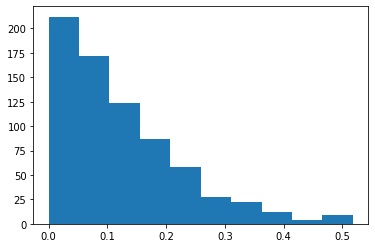

In [20]:
""" Training RCGAN """
# loading pretrained models
regressor = load_model    ('./../data/nns_9HA_noemb_6b6/regressor.h5')
regressor_top = load_model('./../data/nns_9HA_noemb_6b6/regressor_top.h5')
generator = load_model    ('./../data/nns_9HA_noemb_6b6/generator_new.h5')
discriminator= load_model ('./../data/nns_9HA_noemb_6b6/discriminator_new.h5')
"""
regressor_top.trainable = False
regressor.trainable = False

# SMILES related information
max_gen_atoms = 9
bond_max = 9
MAX_NB_WORDS = 23
MAX_SEQUENCE_LENGTH = 35

epochs = 120 
batch_size = 64
batches = y_train.shape[0] // batch_size
threshold = 0.3 # defining accurate samples
reinforce_n = 50 # 5*reinforce_n = fake sampling
reinforce_sample = 1000 # how many samples generated for Reinforcement

# variable for storing generated data
G_Losses = []
D_Losses = []
R_Losses = []
D_Losses_real = []
D_Losses_fake = []

for e in range(epochs):
    start = time.time()
    D_loss = []
    G_loss = []
    R_loss = []
    D_loss_real = []
    D_loss_fake = []
    
    for b in range(batches):
        
        regressor_top.trainable = False
        regressor.trainable = False

        idx = np.arange(b * batch_size, (b + 1) * batch_size)
        # rearrange the samples 
        idx = np.random.choice(idx, batch_size, replace = False)
        
        x_smiles_train = X_smiles_train[idx] 
        batch_y = y_train[idx]
        
        batch_z = np.random.normal(0, 1, size = (batch_size, 128))
        
        atoms_embedding, bonds_embedding, _ = encoder.predict([x_smiles_train])
        dec_embedding = np.concatenate([atoms_embedding, bonds_embedding], axis = -1)
        
        gen_atoms_embedding, gen_bonds_embedding = generator.predict([batch_z, batch_y])
        
        gen_dec_embedding = np.concatenate([gen_atoms_embedding, gen_bonds_embedding], axis = -1)
        softmax_smiles = decoder.predict(gen_dec_embedding)[0]
        argmax_smiles = np.argmax(softmax_smiles, axis = 2)
        smiles = to_categorical(argmax_smiles, num_classes=23)
        SHAPE = list(smiles.shape) + [1]
        smiles = smiles.reshape(SHAPE)
        latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles])
        gen_pred = regressor.predict([latent_encoder_atom, latent_encoder_bond]).reshape([-1])
        
        regressor.trainable = True
        r_loss = regressor.train_on_batch([atoms_embedding, bonds_embedding], batch_y)
        R_loss.append(r_loss)
        regressor.trainable = False

        discriminator.trainable = True
        # original was 3!
        d = 3
        #if b<100:
        #    d=1
        for _ in range(d):
            d_loss_real = discriminator.train_on_batch([atoms_embedding,bonds_embedding, batch_y],
                                                       [1 * np.ones((batch_size, 1))])
            d_loss_fake = discriminator.train_on_batch([gen_atoms_embedding,gen_bonds_embedding, batch_y],
                                                       [np.zeros((batch_size, 1))])

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        D_loss.append(d_loss)
        D_loss_real.append (d_loss_real)
        D_loss_fake.append (d_loss_fake)
        discriminator.trainable = False
        
        regressor_top.trainable = False
        regressor.trainable = False

        #for _ in range(d):
        g_loss = combined.train_on_batch([batch_z, batch_y], [1 * np.ones((batch_size, 1)), batch_y])
        G_loss.append(g_loss)
    
    D_Losses.append(np.mean(D_loss))
    D_Losses_real.append(np.mean(D_loss_real))
    D_Losses_fake.append(np.mean(D_loss_fake))
    G_Losses.append(np.mean(G_loss))
    R_Losses.append(np.mean(R_loss))
    
    print('====')
    print('Current epoch: {}/{}'.format((e + 1), epochs))
    print ('D Loss Real: {}'.format(np.mean(D_loss_real)))
    print ('D Loss Fake: {}'.format(np.mean(D_loss_fake)))
    print('D Loss: {}'.format(np.mean(D_loss)))
    print('G Loss: {}'.format(np.mean(G_loss)))
    print('R Loss: {}'.format(np.mean(R_loss)))
    print('====')
    print()

    
    # Reinforcement
    gen_error = []
    gen_smiles = []
    gen_valid_smiles = []
    gen_X_atoms = []
    gen_X_bonds = []
    predcv_AE_latent = []
    embeddings = []
    sample_ys = []
    valid_smiles_index = []
    for _ in range(reinforce_sample):
        sample_y = np.random.uniform(s_min_dataset, s_max_dataset, size = [1,])
        sample_y = np.round(sample_y, 4)
        sample_y = (sample_y - s_min_norm) / (s_max_norm - s_min_norm)
        sample_ys.append(sample_y)

        sample_z = np.random.normal(0, 1, size = (1, 128))

        sample_atoms_embedding, sample_bonds_embedding = generator.predict([sample_z, sample_y])
        embeddings.append((sample_atoms_embedding, sample_bonds_embedding))
        
        dec_embedding = np.concatenate([sample_atoms_embedding, sample_bonds_embedding], axis = -1)
        softmax_smiles = decoder.predict(dec_embedding)[0]
        argmax_smiles = np.argmax(softmax_smiles, axis = 2).reshape([-1])
        smiles = to_categorical(argmax_smiles, num_classes=23)
        SHAPE = [1] + list(smiles.shape) + [1]
        smiles = smiles.reshape(SHAPE)
        c_smiles = ''
        for s in argmax_smiles:
            c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
        
        if _==0:
            #print ("Gen. sample Reinforce center from Decoder", smiles)
            print ('"   "   converted to SMILES"',c_smiles)
        gen_smiles.append(c_smiles)
        latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles])
        reg_pred = regressor.predict([latent_encoder_atom, latent_encoder_bond])
        
        pred, desire = reg_pred[0][0], sample_y[0]
        gen_error.append(np.abs((pred - desire) / desire))

        
    gen_error = np.asarray(gen_error)
    # two validity defined: 
    # sanitizing and less than 9HA: valid, 
    # without sanitizing: valid 0    
    valid = 0
    valid0 = 0
    idx_ = []
    idx0_ = []
    for iter_, smiles in enumerate(gen_smiles):
        if ' ' in smiles[:-1]:
            continue
        m  = Chem.MolFromSmiles(smiles[:-1], sanitize=True)
        m0 = Chem.MolFromSmiles(smiles[:-1], sanitize=False)
        if m0 is not None:
            valid0 += 1
            idx0_.append(iter_)
        if m is not None:
            if len(construct_atomic_number_array(m)) <= 12:
                valid += 1
                idx_.append(iter_)
                try:
                    gen_smiles [iter_] = Chem.MolToSmiles(m)
                    print (Chem.MolToSmiles(m))
                    print ("Hc_des", sample_ys[iter_])
                    print ("error", gen_error[iter_])
                except:
                    pass
    idx_ = np.asarray(idx_)
    idx0_ = np.asarray(idx0_)

    validity = [gen_smiles[jj] for jj in idx0_ ]
    validity = pd.DataFrame(validity)
    validity = validity.drop_duplicates()

    validity_sanitize = [gen_smiles[jj] for jj in idx_ ]
    validity_sanitize = pd.DataFrame(validity_sanitize)
    validity_sanitize = validity_sanitize.drop_duplicates()

    if (e + 1) % 100 == 0:
        reinforce_n += 10

    # invalid smiles:
    fake_indices1 = np.setdiff1d(np.arange(reinforce_sample), np.asarray(idx_))
    fake_indices2 = np.intersect1d(np.where(gen_error > threshold)[0], idx_)
    fake_indices = np.concatenate ((fake_indices1, fake_indices2))
    fake_indices = np.random.choice(fake_indices, reinforce_n * 5, replace = False)

    real_indices_ = np.intersect1d(np.where(gen_error < threshold)[0], idx_)
    sample_size =  len(real_indices_)
    real_indices = np.random.choice(real_indices_, sample_size, replace = False)
    
    # Activating Reinforcement 
    if e >= 0:
        discriminator.trainable = True
        regressor_top.trainable = False
        regressor.trainable = False
        for real_index in real_indices:
            #real_latent = regressor_top.predict([embeddings[real_index][0], embeddings[real_index][1]])
            _ = discriminator.train_on_batch([embeddings[real_index][0], embeddings[real_index][1], sample_ys[real_index]],
                                             [1 * np.ones((1, 1))])

        for fake_index in fake_indices:
            #fake_latent = regressor_top.predict([embeddings[fake_index][0], embeddings[fake_index][1]])
            _ = discriminator.train_on_batch([embeddings[fake_index][0], embeddings[fake_index][1] , sample_ys[fake_index]],
                                             [np.zeros((1, 1))])
        discriminator.trainable = False

    # ==== #
    try:
        print('Currently valid SMILES (No chemical_beauty and sanitize off): {}'.format(valid0))
        print('Currently valid SMILES Unique (No chemical_beauty and sanitize off): {}'.format(len(validity)))
        print('Currently valid SMILES Sanitized: {}'.format(valid))
        print('Currently valid Unique SMILES Sanitized: {}'.format(len(validity_sanitize)))
        print('Currently satisfying SMILES: {}'.format(len(real_indices_)))
        print('Currently unique satisfying generation: {}'.format(len(np.unique(np.array(gen_smiles)[real_indices_]))))
        print('Gen Sample is: {}, for {}'.format(c_smiles, sample_y))
        print('Predicted val: {}'.format(reg_pred))
        print('====')
        print()
    except:
        pass

    if (e + 1) % 5 == 0:
        plt.close()
        fig, ax = plt.subplots(figsize = (12, 10))
        ax.tick_params(axis='both', which='major', labelsize=30)
        plt.plot(G_Losses, color='blue')
        plt.plot(D_Losses, color='red')
        plt.xlabel('epochs', fontsize=35)
        plt.ylabel('loss', fontsize=35)
        mpl.rcParams['axes.linewidth'] = 2.5
        #plt.plot(R_Losses)
        plt.legend(['G Loss', 'D Loss'], fontsize=30)
        plt.savefig("G_D_losses{}.png".format (e+1))
    n_unique = len(np.unique(np.array(gen_smiles)[real_indices_]))
    n_valid = valid
    if valid > 450 and n_unique > 350:
        print('Criteria has satisified, training has ended')
        break

    end = time.time()
    print ("time for current epoch: ", (end - start))


with open('GAN_loss.pickle', 'wb') as f:
    pickle.dump((G_Losses, D_Losses, R_Losses), f)

# Saving the currently trained models
#regressor.save('regressor.h5')
#regressor_top.save('regressor_top.h5')
generator.save('./../data/nns_9HA_noemb_6b6/generator_new.h5')
discriminator.save('./../data/nns_9HA_noemb_6b6/discriminator_new.h5')

##====#

# Generation Study

#regressor = load_model('regressor.h5')
#regressor_top = load_model('regressor_top.h5')
#generator = load_model    ('./../data/nns_9HA_noemb_6b6/generator_new.h5')
#discriminator = load_model('./../data/nns_9HA_noemb_6b6/discriminator_new.h5')

encoder = load_model('./../data/nns_9HA_noemb_6b6/encoder_newencinp.h5')
decoder = load_model('./../data/nns_9HA_noemb_6b6/decoder_newencinp.h5')

# Generation workflow
# 1. Given a desired heat capacity
# 2. Generate 10,000 samples of SMILES embedding
# 3. Select the ones with small relative errors (< 10%)
# 4. Transfer them to SMILES
# 5. Filter out the invalid SMILES

# Generate 500 different values of heat capacities
"""
from progressbar import ProgressBar
N = 30
n_sample = 700

gen_error = []
gen_smiles = []
sample_ys = []
preds = []
gen_atoms_embedding = []
gen_bonds_embedding = []

regressor_top.trainable = False
regressor.trainable = False
generator.trainable = False
discriminator.trainable = False

np.random.seed(100)

pbar = ProgressBar()
for hc in pbar(range(n_sample)):
    try:
        # get it back to original of s_min to s_max
        sample_y = np.random.uniform(s_min_norm, s_max_norm, size=[1,])
        print (sample_y)
        sample_y = np.round(sample_y, 4)
        sample_y = sample_y * np.ones([N,])
        sample_y_ = (sample_y - s_min_norm) / (s_max_norm - s_min_norm)
        sample_z = np.random.normal(0, 1, size = (N, 128))

        regressor_top.trainable = False
        regressor.trainable = False

        sample_atoms_embedding, sample_bonds_embedding = generator.predict([sample_z, sample_y_])
        dec_embedding = np.concatenate([sample_atoms_embedding, sample_bonds_embedding], axis = -1)
        
        softmax_smiles = decoder.predict(dec_embedding)[0]
        argmax_smiles = np.argmax(softmax_smiles, axis = 2)
        print ('shape argmax_smiles', argmax_smiles.shape)
        smiles = to_categorical(argmax_smiles, num_classes=23)
        SHAPE = list(smiles.shape) + [1] 
        print ('shape line 767', SHAPE) 
        smiles = smiles.reshape(SHAPE)
        
        latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles])
        pred = regressor.predict([latent_encoder_atom, latent_encoder_bond]).reshape([-1])
        pred = pred * (s_max_norm - s_min_norm) + s_min_norm

        gen_errors = np.abs((pred - sample_y) / sample_y).reshape([-1])

        #accurate = np.where(gen_errors <= 0.2)[0]
        #gen_errors = gen_errors[accurate]
        #pred = pred[accurate]

        #sample_y = sample_y[accurate]
        #sample_atoms_embedding = sample_atoms_embedding[accurate]
        #sample_bonds_embedding = sample_bonds_embedding[accurate]

        smiles = decoder.predict(dec_embedding)[0]
        smiles = np.argmax(smiles, axis = 2).reshape(smiles.shape[0], 35)

        generated_smiles = []
        for S in smiles:
            c_smiles = ''
            for s in S:
                c_smiles += tokenizer[s]
            c_smiles = c_smiles.rstrip()
            generated_smiles.append(c_smiles)
        generated_smiles = np.array(generated_smiles)
        #generated_smiles = generated_smiles [accurate]
        all_gen_smiles = []
        idx = []
        for i, smiles in enumerate(generated_smiles):
            all_gen_smiles.append(smiles[:-1])

            if ' ' in smiles[:-1]:
                continue
            #m = Chem.MolFromSmiles(smiles[:-1], sanitize=False)
            m = Chem.MolFromSmiles(smiles[:-1], sanitize=True)
            if m is not None:
                if len(construct_atomic_number_array(m)) <= 9:
                    idx.append(i)

        idx = np.array(idx)
        all_gen_smiles = np.array(all_gen_smiles)
        print ('all gen smiels shape', all_gen_smiles.shape)
        print ('gen_errors shape', gen_errors.shape)
        gen_smiles.extend(list(all_gen_smiles[idx]))
        gen_error.extend(list(gen_errors[idx]))
        sample_ys.extend(list(sample_y[idx]))
        gen_atoms_embedding.extend(sample_atoms_embedding[idx])
        gen_bonds_embedding.extend(sample_bonds_embedding[idx])

        preds.extend(list(pred[idx]))
    except:
        print('Did not discover SMILES for HC: {}'.format(sample_y))
        pass    


output = {}

for i, s in enumerate (gen_smiles):
    ss = Chem.MolToSmiles(Chem.MolFromSmiles(s, sanitize=True))
    gen_smiles[i] = ss

output['SMILES'] = gen_smiles
output['des_cv'] = sample_ys
output['pred_cv'] = preds
output['Err_pred_des'] = gen_error

plt.close()
plt.hist(gen_error)
plt.savefig("gen_error_hist.png")

output = pd.DataFrame(output)
output.reset_index(drop = True, inplace = True)
output.to_csv ('./../experiments/regular_9HA_6b6latent/Regular_noscreen.csv', index=False)
## Statistics  (# pred=True value, Des=prediction)

# total # of samples
N = len(gen_error)
# Explained Variance R2 from sklearn.metrics.explained_variance_score
explained_variance_R2_pred_des = explained_variance_score(output['des_cv'], output['pred_cv'])
print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
rsquared = r2_score (output['des_cv'], output['pred_cv'])
print ("r squared r**2", rsquared)
# mean absolute error 
MAE_pred_des = mean_absolute_error(output['pred_cv'], output['des_cv'])
print ("MAE_pred_des", MAE_pred_des)
# Fractioned MAE, more normalized
Fractioned_MAE_pred_des = 0
for pred, des in zip(output['pred_cv'], output['des_cv']):
    Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(des-pred)/des
Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/N
print ("Fractioned MAE_pred_des", Fractioned_MAE_pred_des)

# root mean squared error (RMSE), sqrt(sklearn ouputs MSE)
RMSE_pred_des = mean_squared_error(output['pred_cv'], output['des_cv'])**0.5
print ("RMSE_pred_des", RMSE_pred_des)

Fractioned_RMSE_pred_des = 0
for pred, des in zip(output['pred_cv'], output['des_cv']):
    Fractioned_RMSE_pred_des = Fractioned_RMSE_pred_des + ((des-pred)/des)**2
Fractioned_RMSE_pred_des = (Fractioned_RMSE_pred_des/N)**0.5
print ("Fractioned_RMSE_pred_des", Fractioned_RMSE_pred_des)

#output = pd.DataFrame(output)
# do not drop duplicate
output2 = output.drop_duplicates(['SMILES'])
#gen_atoms_embedding = np.array(gen_atoms_embedding)
#gen_bonds_embedding = np.array(train_atoms_embedding)

"""
# ANALYSIS
X_atoms_train_ = train_atoms_embedding.reshape([train_atoms_embedding.shape[0], 
                                        6 * 6])
X_bonds_train_ = train_bonds_embedding.reshape([train_bonds_embedding.shape[0], 
                                        6 * 6])

X_atoms_test_ = gen_atoms_embedding.reshape([gen_atoms_embedding.shape[0],
                                      6 * 6])
X_bonds_test_ = gen_bonds_embedding.reshape([gen_bonds_embedding.shape[0], 
                                      6 * 6])

pca_1 = PCA(n_components = 2)
X_atoms_train_ = pca_1.fit_transform(X_atoms_train_)
X_atoms_test_ = pca_1.transform(X_atoms_test_)

pca_2 = PCA(n_components = 2)
X_bonds_train_ = pca_2.fit_transform(X_bonds_train_)
X_bonds_test_ = pca_2.transform(X_bonds_test_)

# Atoms Distribution
plt.close()
plt.scatter(X_atoms_train_[:,0], X_atoms_train_[:,1], alpha = 0.3, c = 'blue');
plt.savefig("train_atom_dist.png")
#plt.close()
plt.scatter(X_atoms_test_[:,0], X_atoms_test_[:,1], alpha = 0.3, c = 'red');
plt.savefig("test_atom_dist.png")
####

# Bonds Distribution
plt.close()
plt.scatter(X_bonds_train_[:,0], X_bonds_train_[:,1], alpha = 0.3, c = 'blue');
plt.savefig("train_bonds_dist.png")
#plt.close()
plt.scatter(X_bonds_test_[:,0], X_bonds_test_[:,1], alpha = 0.3, c = 'red');
plt.savefig("test_bonds_dist.png")
# 31/500 failed (N = 10000)
# 2/50 failed (N = 50000)
"""
#output.reset_index(drop = True, inplace = True)
output2.reset_index(drop = True, inplace = True)
#output.to_csv ('./../experiments/regular_9HA_6b6latent/Regular_noscreen.csv', index = False)
output2.to_csv('./../experiments/regular_9HA_6b6latent/Regular_NODUP_noscreen.csv', index = False)
"""with open('gen_pickles.pickle', 'wb') as f:
    pickle.dump(gen_unique_pickles, f)
"""

In [18]:
explained_variance_R2_pred_des = explained_variance_score(output['des_cv'], output['pred_cv'])
print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
rsquared = r2_score (output['des_cv'], output['pred_cv'])
print ("r squared r**2", rsquared)

explained_varice_R2_pred_des 0.28056052686420296
r squared r**2 0.27832566253410707
